# Networks Project: Barabási-Albert model

In [3]:
#%pip install ipython-autotime
#%load_ext autotime

In [580]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
from scipy.optimize import curve_fit
from collections import Counter
from scipy.stats import kstest

%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 10]
plt.rcParams.update({'font.size': 22})
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['ytick.direction'] = "in"
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 3.5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 3.5
plt.rcParams['ytick.minor.width'] = 1

time: 265 ms


In [487]:
def p_pref(m, ks):
    p_pref = []
    for k in ks:
        p = (2*m*(m+1))/(k*(k+1)*(k+2))
        p_pref.append(p)
    return p_pref

def p_rand(m, ks):
    p_rand = []
    for k in ks:
        p = ((m/(m+1))**(k-m)) * (1/(m+1))
        p_rand.append(p)
    return p_rand

def p_walk(m, ks):
    p_walk = []
    for k in ks:
        p = (12*m*(3*m+1)*(3*m+2)*(3*m+3))/((k+2*m+4)*(k+2*m+3)*(k+2*m+2)*(k+2*m+1)*(k+2*m))
        p_walk.append(p)
    return p_walk

def k1_pref(N, m):
    k1_pref = (-1 + np.sqrt(1 + 4*N*m*(m+1)))/2
    return k1_pref

def k1_rand(N, m):
    k1_rand = m - (np.log(N)/(np.log(m)-np.log(m+1)))
    return k1_rand

def k1_std(N, m, num, att="pref", q=0):
    max_degs = []
    for i in range(num):
        degrees = deg_dist_logbin(N, m, 1, att=att, q=0)
        max_degs.append(np.max(degrees))
    k1_std = np.std(max_degs)
    return k1_std

def linear_func(x, a, b):
    return a*x + b

def power_func(x, a, b):
    return a*x**b

def exp_func(x, a, b):
    return a*np.exp(b*x)

def gauss_func(x, mean, sigma):
    return (1/(sigma *np.sqrt(2*np.pi))) * np.exp(-0.5 * ((x - mean)/sigma)**2)

def pref_att(attachments, m):
    target_nodes = []
    while len(target_nodes) < m:
        new_node = random.choice(attachments)
        while new_node in target_nodes:       
            new_node = random.choice(attachments)
        target_nodes.append(new_node)
    return target_nodes

def rand_att(nodes, m):
    target_nodes = []
    while len(target_nodes) < m:
        new_node = random.choice(nodes)
        while new_node in target_nodes:
            new_node = random.choice(nodes)
        target_nodes.append(new_node)
    return target_nodes

def walk_att(nodes, edges, neighbours, m, q):
    if q == 1:
        raise Exception("Random walk will continue indefinitely.")
        
    target_nodes = []
    initial_targets = rand_att(nodes, m)
    prob = [q, 1-q]
    for node in initial_targets:
        repeat = True
        while repeat:
            walk = np.random.choice([True, False], p=prob)
            while walk:
                node = random.choice(neighbours[node])
                walk = np.random.choice([True, False], p=prob)

            if node not in target_nodes:
                target_nodes.append(node)
                repeat = False
            else:
                repeat = True
    return target_nodes

def deg_dist_logbin(N, m, num, att="pref", q=0):
    total_degrees = []
    for i in range(num):
        nodes, edges = ba_model(N, m, att=att, q=q)
        attachment = list(np.ravel(edges))
        degrees = np.unique(attachment, return_counts=True)
        total_degrees.extend(degrees[1])
    return total_degrees

def deg_dist(N, m, num, att="pref", q=0):
    total_degrees = []
    for i in range(num):
        nodes, edges = ba_model(N, m, att=att, q=q)
        attachment = list(np.ravel(edges))
        degrees = np.unique(attachment, return_counts=True)
        total_degrees.extend(degrees[1])
    freq = [0 for i in range(N)]
    for i in range(len(total_degrees)):
        freq[total_degrees[i]] += 1
    size = [i for i in range(N)]
    probs = np.array(freq)/sum(freq)
    return total_degrees, size, freq, probs

def max_deg(N, m, num, att="pref", q=0):
    max_degs = []
    for i in range(num):
        degrees = deg_dist_logbin(N, m, 1, att=att, q=0)
        max_degs.append(np.max(degrees))
    max_deg = np.average(max_degs)
    return max_deg, max_degs

def std_func(N, m, num, att="pref", q=0, scale=1.):
    k1, k1_list = max_deg(N, m, num, att=att)
    total_degrees = []
    std_list = []
    for i in range(num):
        padding = [0 for i in range(int(k1+2))]
        nodes, edges = ba_model(N, m, att=att, q=q)
        attachment = list(np.ravel(edges))
        degrees = np.unique(attachment, return_counts=True)
        bin_centres, bin_probs = logbin(degrees[1], scale=scale, zeros=False, bin_zero=True)
        padding[:len(bin_probs)] = bin_probs
        std_list.append(padding)
    std = np.std(std_list, axis=0)
    return std

def logbin(data, scale = 1., zeros = False, bin_zero=False):
    """
    logbin(data, scale = 1., zeros = False)

    Log-bin frequency of unique integer values in data. Returns probabilities
    for each bin.

    Array, data, is a 1-d array containing full set of event sizes for a
    given process in no particular order. For instance, in the Oslo Model
    the array may contain the avalanche size recorded at each time step. For
    a complex network, the array may contain the degree of each node in the
    network. The logbin function finds the frequency of each unique value in
    the data array. The function then bins these frequencies in logarithmically
    increasing bin sizes controlled by the scale parameter.

    Minimum binsize is always 1. Bin edges are lowered to nearest integer. Bins
    are always unique, i.e. two different float bin edges corresponding to the
    same integer interval will not be included twice. Note, rounding to integer
    values results in noise at small event sizes.

    Parameters
    ----------

    data: array_like, 1 dimensional, non-negative integers
          Input array. (e.g. Raw avalanche size data in Oslo model.)

    scale: float, greater or equal to 1.
          Scale parameter controlling the growth of bin sizes.
          If scale = 1., function will return frequency of each unique integer
          value in data with no binning.

    zeros: boolean
          Set zeros = True if you want binning function to consider events of
          size 0.
          Note that output cannot be plotted on log-log scale if data contains
          zeros. If zeros = False, events of size 0 will be removed from data.

    Returns
    -------

    x: array_like, 1 dimensional
          Array of coordinates for bin centres calculated using geometric mean
          of bin edges. Bins with a count of 0 will not be returned.
    y: array_like, 1 dimensional
          Array of normalised frequency counts within each bin. Bins with a
          count of 0 will not be returned.
    """
    if scale < 1:
        raise ValueError('Function requires scale >= 1.')
    count = np.bincount(data)
    tot = np.sum(count)
    smax = np.max(data)
    if scale > 1:
        jmax = np.ceil(np.log(smax)/np.log(scale))
        if zeros:
            binedges = scale ** np.arange(jmax + 1)
            binedges[0] = 0
        else:
            binedges = scale ** np.arange(1,jmax + 1)
            # count = count[1:]
        binedges = np.unique(binedges.astype('uint64'))
        x = (binedges[:-1] * (binedges[1:]-1)) ** 0.5
        y = np.zeros_like(x)
        count = count.astype('float')
        for i in range(len(y)):
            y[i] = np.sum(count[binedges[i]:binedges[i+1]]/(binedges[i+1] - binedges[i]))
            # print(binedges[i],binedges[i+1])
        # print(smax,jmax,binedges,x)
        # print(x,y)
    else:
        x = np.nonzero(count)[0]
        y = count[count != 0].astype('float')
        if zeros != True and x[0] == 0:
            x = x[1:]
            y = y[1:]
    y /= tot
    
    if bin_zero==False:
        x = x[y!=0]
        y = y[y!=0]
        
    return x,y
        
def ba_model(N, m, att="pref", seed=None, q=0, printon=False, savenx=False, graph=False):
    
    if (N < 20):
        printon=True
    
    if m < 1 or m >= N:
        raise nx.NetworkXError("BA network must satisfy m >= 1 and m < n.")
    
    if seed is None:
        random.seed()
    else:
        random.seed(seed)
        
    G = nx.complete_graph(m+1)
    nodes = list(G.nodes)
    edges = list(G.edges)
    neighbours = [[n for n in G.neighbors(i)] for i in nodes]
    attachments = list(np.ravel(edges))
    
    for t in range(m, N):
        if att == "pref":
            target_nodes = pref_att(attachments, m)
        elif att == "rand":
            target_nodes = rand_att(nodes, m)
        elif att == "walk":
            target_nodes = walk_att(nodes, edges, neighbours, m, q)
        else: 
            raise Exception("Not an attachment option.")
            break
        
        neighbours.append([])
        nodes.append(t)
        
        for i in range(len(target_nodes)):
            edges.append((t, target_nodes[i]))
            attachments.append(target_nodes[i])
            attachments.append(t)  
            neighbours[t].append(target_nodes[i])
            neighbours[target_nodes[i]].append(t)
            
            if printon:
                print('--- new edge from ' + str(t)
                        + ' to ' + str(target_nodes[i]))
            if graph:
                G.add_edge(t, target_nodes[i])
            
        if graph:
            G.add_node(t)
          
    if savenx:
        filename = "ba_N" + str(N) + "_m" + str(m) + '.graphml'
        outputdir = "/Users/harvey/networks-project/output/"
        outputfile = os.path.join(outputdir, filename)
        print("Writing network to " + outputfile)
        nx.write_graphml(G, outputfile)
        
    if graph:
        return G
    
    return nodes, edges

time: 20.3 ms


## Testing the Model

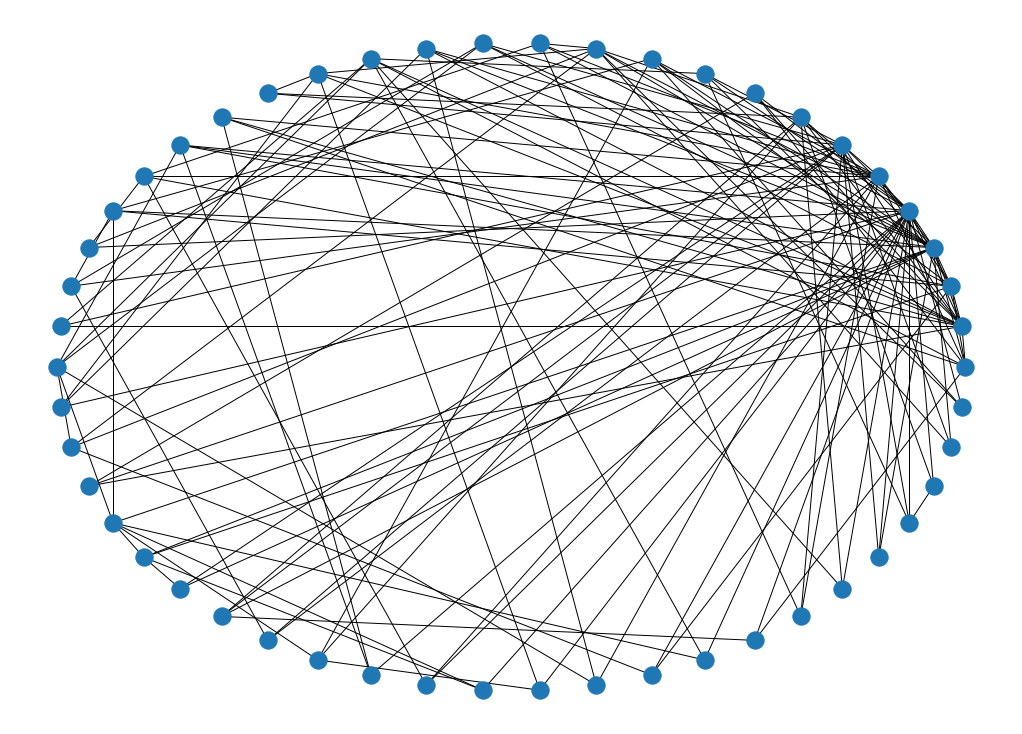

time: 285 ms


In [1029]:
N = 50
m = 3
ba = ba_model(N, m, seed=0, graph=True)
nx.draw(ba, pos = nx.circular_layout(ba))

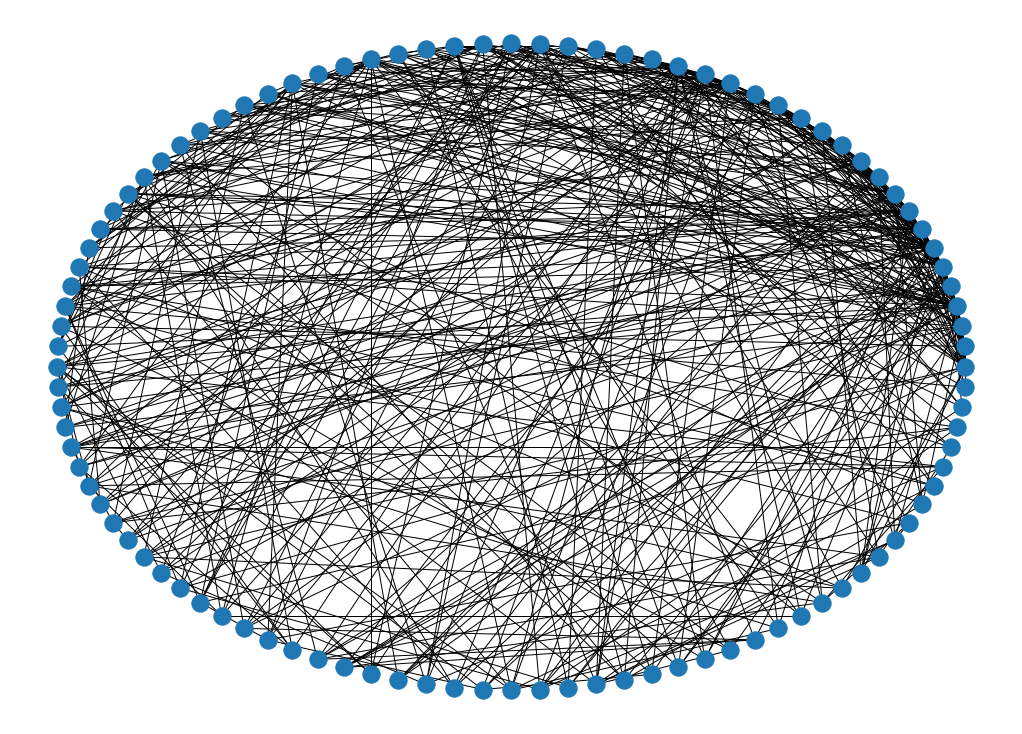

In [21]:
N = 100
m = 2
ba = ba_model(N, m, seed=0, graph=True)
nx.draw(ba, pos=nx.circular_layout(ba))

## Theoretical degree distributions

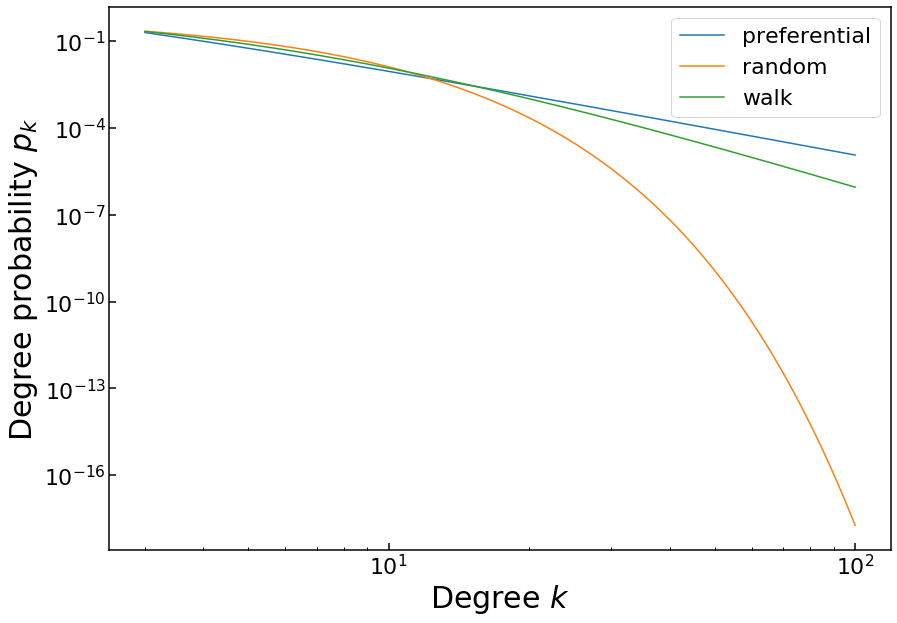

time: 447 ms


In [35]:
m = 2
ks = np.linspace(3, 100, 1000)

plt.loglog(ks, p_pref(m, ks), label="preferential")
plt.loglog(ks, p_rand(m, ks), label="random")
plt.loglog(ks, p_walk(m, ks), label="walk")

plt.xlabel("Degree $k$", fontsize=30)
plt.ylabel("Degree probability $p_k$", fontsize=30)
plt.legend()
plt.show()

# Phase 1: Preferential Attachment

Average degree for m=3:

In [398]:
N = 100000
m = 3
num = 100
degrees = deg_dist_logbin(N, m, num, att="pref")
print(np.average(degrees))

5.99994
time: 3min 48s


Average degree for m=81:

In [399]:
N = 100000
m = 81
num = 100
degrees = deg_dist_logbin(N, m, num, att="pref")
print(np.average(degrees))

161.9352
time: 16min 9s


## N=1,000,000 and m=3 for 100 iterations

In [ ]:
N = 1000000
m = 3
num = 100
att = "pref"
degrees, size, freq, prob = deg_dist(N, m, num, att)

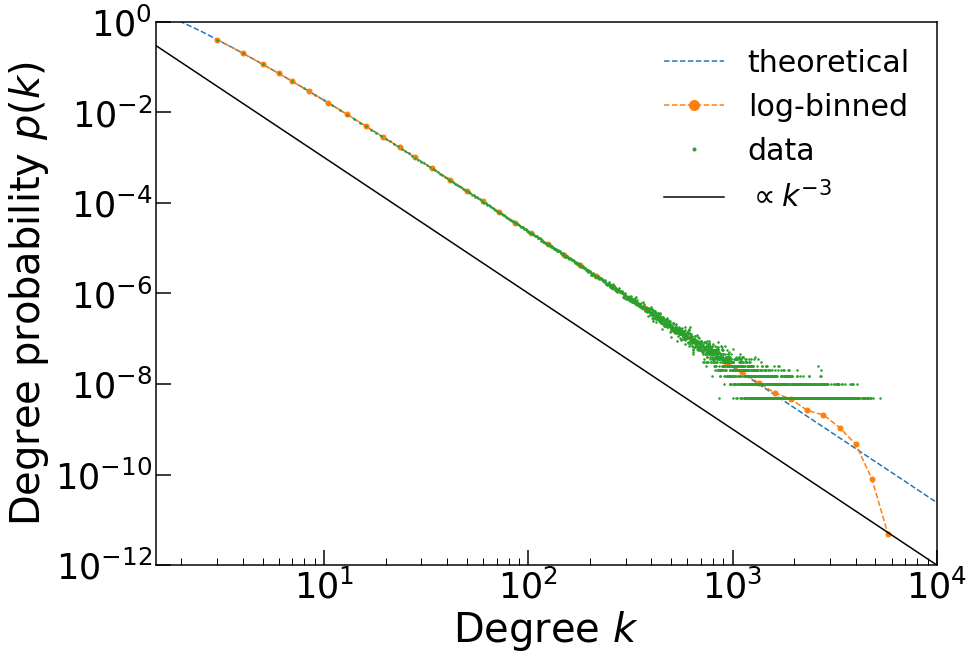

time: 4.65 s


In [713]:
degrees_Ne6 = np.load('BA_pref_Ne6_m3.npy', allow_pickle=True)
bin_centres1, bin_probs1 = logbin(degrees_Ne6, scale=1.2, zeros=False)
bin_centres2, bin_probs2 = logbin(degrees_Ne6, scale=1., zeros=False)

ks = np.linspace(np.min(bin_centres1)-100, np.max(bin_centres1)+100000, 100000)
plt.loglog(ks, p_pref(3, ks), '--', label="theoretical")
plt.loglog(bin_centres1, bin_probs1, '.--', label="log-binned", markersize=10)
plt.loglog(bin_centres2, bin_probs2, '.',label="data", markersize=3)

p = power_func(ks, 1, -3) 
plt.loglog(ks, p, '-', color="black", label=r"$\propto k^{-3}$")
plt.xlabel("Degree $k$", fontsize=40)
plt.ylabel("Degree probability $p(k)$", fontsize=40)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.legend(fontsize=30, markerscale=2, frameon=False)
plt.axis([1.5,10000,1e-12,1])
plt.show()

## Constant $N=100000$, vary $m$

In [ ]:
N = 100000
num = 10
att = "pref"

degrees_m1 = deg_dist_logbin(N, 1, num, att)
degrees_m3 = deg_dist_logbin(N, 3, num, att)
degrees_m9 = deg_dist_logbin(N, 9, num, att)
degrees_m27 = deg_dist_logbin(N, 27, num, att)
degrees_m81 = deg_dist_logbin(N, 81, num, att)

bin_centres1, bin_probs1 = logbin(degrees_m1, scale=1.2, zeros=False)
bin_centres3, bin_probs3 = logbin(degrees_m3, scale=1.2, zeros=False)
bin_centres9, bin_probs9 = logbin(degrees_m9, scale=1.2, zeros=False)
bin_centres27, bin_probs27 = logbin(degrees_m27, scale=1.2, zeros=False)
bin_centres81, bin_probs81 = logbin(degrees_m81, scale=1.2, zeros=False)

In [ ]:
N = 100000
num = 100
att = "pref"

degrees_m1 = deg_dist_logbin(N, 1, num, att)
np.save('BA_pref_Ne5_m1_2.npy', degrees_m1)
degrees_m3 = deg_dist_logbin(N, 3, num, att)
np.save('BA_pref_Ne5_m3_2.npy', degrees_m3)
degrees_m9 = deg_dist_logbin(N, 9, num, att)
np.save('BA_pref_Ne5_m9_2.npy', degrees_m9)
degrees_m27 = deg_dist_logbin(N, 27, num, att)
np.save('BA_pref_Ne5_m27.npy', degrees_m27)
degrees_m81 = deg_dist_logbin(N, 81, num, att)
np.save('BA_pref_Ne5_m81.npy', degrees_m81)

In [887]:
degrees_m1 = np.load('BA_pref_Ne5_m1.npy', allow_pickle=True)
degrees_m3 = np.load('BA_pref_Ne5_m3.npy', allow_pickle=True)
degrees_m9 = np.load('BA_pref_Ne5_m9.npy', allow_pickle=True)
degrees_m27 = np.load('BA_pref_Ne5_m27.npy', allow_pickle=True)
degrees_m81 = np.load('BA_pref_Ne5_m81.npy', allow_pickle=True)

bin_centres1, bin_probs1 = logbin(degrees_m1, scale=1.2, zeros=False)
bin_centres3, bin_probs3 = logbin(degrees_m3, scale=1.2, zeros=False)
bin_centres9, bin_probs9 = logbin(degrees_m9, scale=1.2, zeros=False)
bin_centres27, bin_probs27 = logbin(degrees_m27, scale=1.2, zeros=False)
bin_centres81, bin_probs81 = logbin(degrees_m81, scale=1.2, zeros=False)

time: 834 ms


In [127]:
std_degree1 = std_func(100000, 1, 100)
np.save('BA_pref_Ne5_m1_std.npy', std_degree1)
std_degree3 = std_func(100000, 3, 100)
np.save('BA_pref_Ne5_m3_std.npy', std_degree3)
std_degree9 = std_func(100000, 9, 100)
np.save('BA_pref_Ne5_m9_std.npy', std_degree9)
std_degree27 = std_func(100000, 27, 100)
np.save('BA_pref_Ne5_m27_std.npy', std_degree27)
std_degree81 = std_func(100000, 81, 100)
np.save('BA_pref_Ne5_m81_std.npy', std_degree81)

time: 1h 30min 25s


In [545]:
std_degree1 = np.load('BA_pref_Ne5_m1_std.npy', allow_pickle=True)
std_degree3 = np.load('BA_pref_Ne5_m3_std.npy', allow_pickle=True)
std_degree9 = np.load('BA_pref_Ne5_m9_std.npy', allow_pickle=True)
std_degree27 = np.load('BA_pref_Ne5_m27_std.npy', allow_pickle=True)
std_degree81 = np.load('BA_pref_Ne5_m81_std.npy', allow_pickle=True)

time: 39 ms


/Users/harvey/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


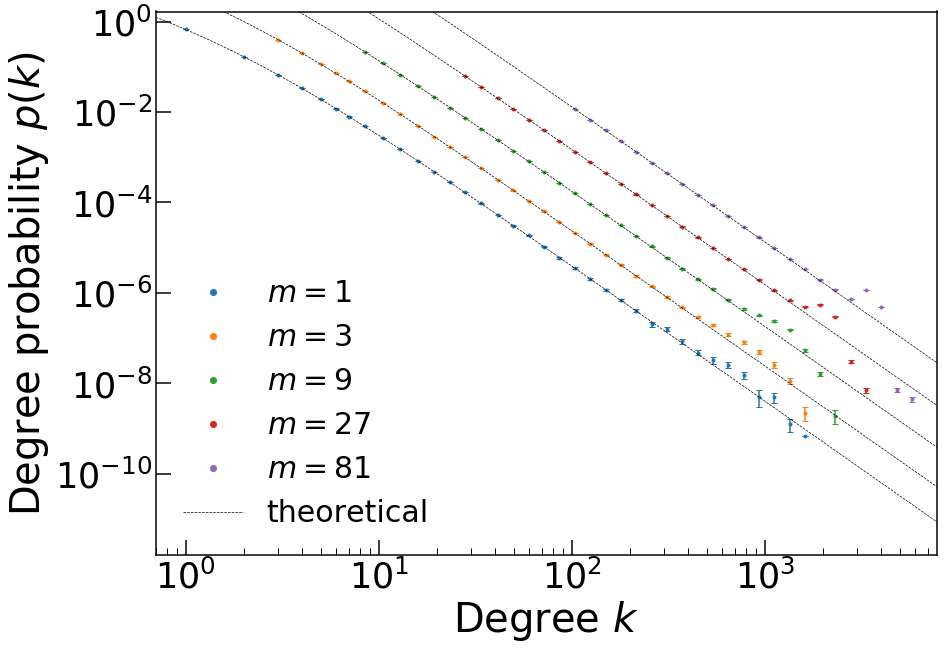

time: 11.8 s


In [804]:
plt.loglog(bin_centres1, bin_probs1, '.', label="$m=1$", color='tab:blue')
plt.loglog(bin_centres3, bin_probs3, '.', label="$m=3$", color='tab:orange')
plt.loglog(bin_centres9, bin_probs9, '.', label="$m=9$", color='tab:green')
plt.loglog(bin_centres27, bin_probs27, '.', label="$m=27$", color='tab:red')
plt.loglog(bin_centres81, bin_probs81, '.', label="$m=81$", color='tab:purple')

plt.errorbar(bin_centres1, bin_probs1, fmt="none", yerr=std_degree1[0:len(bin_centres1)]/10, capsize=3, color='tab:blue')
plt.errorbar(bin_centres3, bin_probs3, fmt="none", yerr=std_degree3[2:len(bin_centres3)+2]/10, capsize=3, color='tab:orange')
plt.errorbar(bin_centres9, bin_probs9, fmt="none", yerr=std_degree9[7:len(bin_centres9)+7]/10, capsize=3, color='tab:green')
plt.errorbar(bin_centres27, bin_probs27, fmt="none", yerr=std_degree27[13:len(bin_centres27)+13]/10, capsize=3, color='tab:red')
plt.errorbar(bin_centres81, bin_probs81, fmt="none", yerr=std_degree81[19:len(bin_centres81)+19]/10, capsize=3, color='tab:purple')

k = np.linspace(np.min(bin_centres1)-0.3, np.max(bin_centres81)+2000, 1000000)
p = power_func(k, 1, -3) 

plt.loglog(k, p_pref(1, k), '--', color="black", label="theoretical", linewidth=0.7)
plt.loglog(k, p_pref(3, k), '--', color="black", linewidth=0.7)
plt.loglog(k, p_pref(9, k), '--', color="black", linewidth=0.7)
plt.loglog(k, p_pref(27, k), '--', color="black", linewidth=0.7)
plt.loglog(k, p_pref(81, k), '--', color="black", linewidth=0.7)

plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 15
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.size'] = 15
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 7
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 7
plt.rcParams['ytick.minor.width'] = 1

#plt.loglog(k, p, '-', color="black", label=r"$\propto k^{-3}$")
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xlabel("Degree $k$", fontsize=40)
plt.ylabel("Degree probability $p(k)$", fontsize=40)
plt.axis([np.min(bin_centres1)-0.3, np.max(bin_centres81)+2000, np.min(bin_probs3)-3, np.max(bin_probs1)+1])
plt.legend(fontsize=30, markerscale=2, frameon=False)
plt.show()

## Cumulative probability distributions for KS:

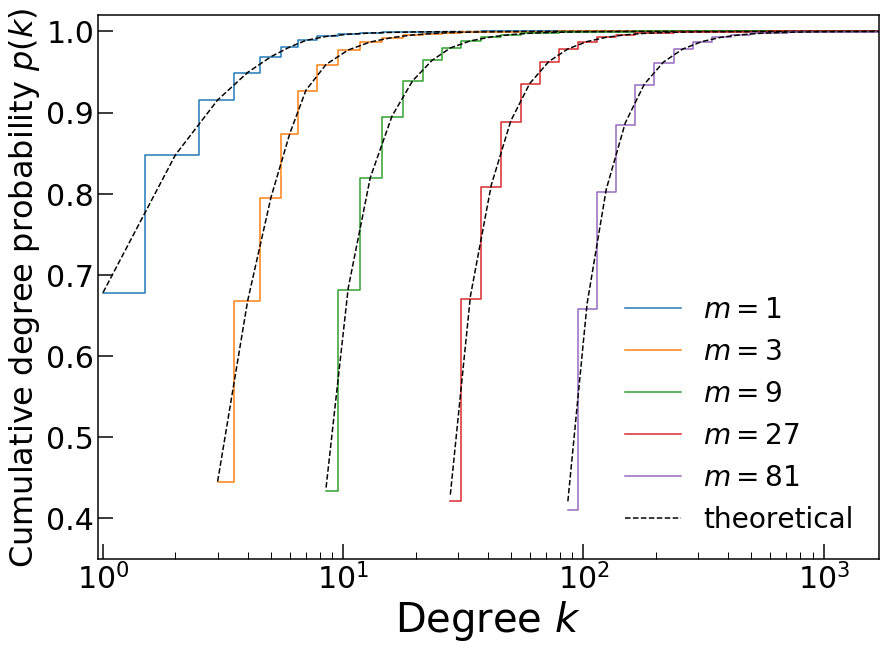

9.043775620698469e-05
0.0007655346305998068
0.0037716249278393343
0.007741823145646365
0.010374911945139953
time: 442 ms


In [928]:
ks1 = np.linspace(np.min(bin_centres1), np.max(bin_centres1), 10000)
cum_data1 = np.cumsum(bin_probs1)/np.sum(bin_probs1)
cum_theory1 = np.cumsum(p_pref(1, bin_centres1))/np.sum(p_pref(1, bin_centres1))
plt.step(bin_centres1, cum_data1, label='$m=1$', color='tab:blue', where='mid')
plt.semilogx(bin_centres1, cum_theory1,'--', color="black")

ks3 = np.linspace(np.min(bin_centres3), np.max(bin_centres3), 10000)
cum_data3 = np.cumsum(bin_probs3)/np.sum(bin_probs3)
cum_theory3 = np.cumsum(p_pref(3, bin_centres3))/np.sum(p_pref(3, bin_centres3))
plt.step(bin_centres3, cum_data3, label = "$m=3$", color='tab:orange', where='mid')
plt.semilogx(bin_centres3, cum_theory3,'--', color="black")

ks9 = np.linspace(np.min(bin_centres9), np.max(bin_centres9), 10000)
cum_data9 = np.cumsum(bin_probs9)/np.sum(bin_probs9)
cum_theory9 = np.cumsum(p_pref(9, bin_centres9))/np.sum(p_pref(9, bin_centres9))
plt.step(bin_centres9, cum_data9, label = "$m=9$", color='tab:green', where='mid')
plt.semilogx(bin_centres9, cum_theory9,'--', color="black")

ks27 = np.linspace(np.min(bin_centres27), np.max(bin_centres27), 10000)
cum_data27 = np.cumsum(bin_probs27)/np.sum(bin_probs27)
cum_theory27 = np.cumsum(p_pref(27, bin_centres27))/np.sum(p_pref(27, bin_centres27))
plt.step(bin_centres27, cum_data27, label = "$m=27$", color='tab:red', where='mid')
plt.semilogx(bin_centres27, cum_theory27,'--', color="black")

ks81 = np.linspace(np.min(bin_centres81), np.max(bin_centres81), 10000)
cum_data81 = np.cumsum(bin_probs81)/np.sum(bin_probs81)
cum_theory81 = np.cumsum(p_pref(81, bin_centres81))/np.sum(p_pref(81, bin_centres81))
plt.step(bin_centres81, cum_data81, label = "$m=81$", color='tab:purple', where='mid')
plt.semilogx(bin_centres81, cum_theory81,'--', color="black", label='theoretical')

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel("Degree $k$", fontsize=40)
plt.ylabel("Cumulative degree probability $p(k)$", fontsize=32)
plt.legend(fontsize=28, markerscale=2, frameon=False)
plt.axis([0.95, 1700, 35e-2, 1.02])
plt.show()

m_list = [bin_centres1, bin_centres3, bin_centres9, bin_centres27, bin_centres81]
cum_theory_list = [cum_theory1, cum_theory3, cum_theory9, cum_theory27, cum_theory81]
cum_data_list = [cum_data1, cum_data3, cum_data9, cum_data27, cum_data81]

max_diff_list = []
for m in range(len(m_list)):
    max_diff = 0
    for i in range(len(m_list)):
        diff = np.linalg.norm(cum_theory_list[m][i] - cum_data_list[m][i])
        if diff > max_diff:
            max_diff = diff
    max_diff_list.append(max_diff)

    print(max_diff)

KS statistics:

In [943]:
n = [len(bin_centres1), len(bin_centres3), len(bin_centres9), len(bin_centres27), len(bin_centres81)]
print(n)
alpha = 0.05
print(max_diff_list)
for D in range(len(max_diff_list)):
    ks_test = max_diff_list[D] - ((1/np.sqrt(n[D])) * np.sqrt(-np.log(alpha/2)))
    print("thresh:", ((1/np.sqrt(n[D])) * np.sqrt(-np.log(alpha/2))))
    print(ks_test)

[2000000, 2000000, 2000000, 2000000, 2000000]
[9.043775620698469e-05, 0.0007655346305998068, 0.0037716249278393343, 0.007741823145646365, 0.010374911945139953]
thresh: 0.0013581015157406195
-0.0012676637595336348
thresh: 0.0013581015157406195
-0.0005925668851408127
thresh: 0.0013581015157406195
0.002413523412098715
thresh: 0.0013581015157406195
0.006383721629905746
thresh: 0.0013581015157406195
0.009016810429399334
time: 2.29 ms


In [885]:
degrees_m1 = np.load('BA_pref_Ne5_m1.npy', allow_pickle=True)
degrees_m3 = np.load('BA_pref_Ne5_m3.npy', allow_pickle=True)
degrees_m9 = np.load('BA_pref_Ne5_m9.npy', allow_pickle=True)
degrees_m27 = np.load('BA_pref_Ne5_m27.npy', allow_pickle=True)
degrees_m81 = np.load('BA_pref_Ne5_m81.npy', allow_pickle=True)

bin_centres1, bin_probs1 = logbin(degrees_m1, scale=1., zeros=False)
bin_centres3, bin_probs3 = logbin(degrees_m3, scale=1., zeros=False)
bin_centres9, bin_probs9 = logbin(degrees_m9, scale=1., zeros=False)
bin_centres27, bin_probs27 = logbin(degrees_m27, scale=1., zeros=False)
bin_centres81, bin_probs81 = logbin(degrees_m81, scale=1., zeros=False)

time: 999 ms


Finding exponent using linear fit:

In [891]:
(m1_yint, m1_grad), cov = curve_fit(power_func, bin_centres1[5:25], bin_probs1[5:25])
(m3_yint, m3_grad), cov = curve_fit(power_func, bin_centres3[6:23], bin_probs3[6:23])
(m5_yint, m5_grad), cov = curve_fit(power_func, bin_centres5[4:22], bin_probs5[4:22])
(m7_yint, m7_grad), cov = curve_fit(power_func, bin_centres7[4:20], bin_probs7[4:20])
(m9_yint, m9_grad), cov = curve_fit(power_func, bin_centres9[4:18], bin_probs9[4:18])
print(m1_grad, m3_grad, m5_grad, m7_grad, m9_grad)

-2.6690562834024605 -2.8045086513519077 -2.8038155235691087 -2.8667754174044493 -2.894681187164102
time: 10.3 ms


Data collapse:

In [141]:
ms = [1, 3, 9, 27, 81]
N = 100000
num = 100
att = "pref"
k1s = []
for m in ms:
    print("m:", m)
    k1, k1_list = max_deg(N, m, num, att=att)
    k1s.append(k1)
               
np.save('BA_pref_k1s_m.npy', k1s)

m: 1
m: 3
m: 9
m: 27
m: 81
time: 1h 49min 46s


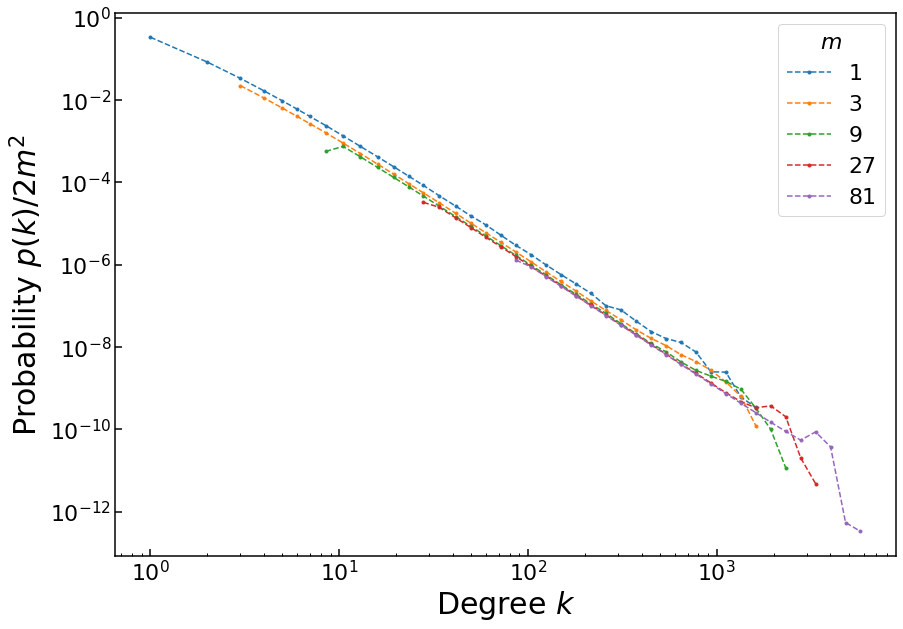

time: 2.67 s


In [581]:
k1s_m = np.load('BA_pref_k1s.npy', allow_pickle=True)

degrees_m1 = np.load('BA_pref_Ne5_m1.npy', allow_pickle=True)
degrees_m3 = np.load('BA_pref_Ne5_m3.npy', allow_pickle=True)
degrees_m9 = np.load('BA_pref_Ne5_m9.npy', allow_pickle=True)
degrees_m27 = np.load('BA_pref_Ne5_m27.npy', allow_pickle=True)
degrees_m81 = np.load('BA_pref_Ne5_m81.npy', allow_pickle=True)

bin_centres1, bin_probs1 = logbin(degrees_m1, scale=1.2, zeros=False)
bin_centres3, bin_probs3 = logbin(degrees_m3, scale=1.2, zeros=False)
bin_centres9, bin_probs9 = logbin(degrees_m9, scale=1.2, zeros=False)
bin_centres27, bin_probs27 = logbin(degrees_m27, scale=1.2, zeros=False)
bin_centres81, bin_probs81 = logbin(degrees_m81, scale=1.2, zeros=False)

plt.loglog(bin_centres1, bin_probs1/2, '.--', label="1")
plt.loglog(bin_centres3, bin_probs3/(2*9), '.--', label="3")
plt.loglog(bin_centres9, bin_probs9/(2*81), '.--', label="9")
plt.loglog(bin_centres27, bin_probs27/(2*27**2), '.--', label="27")
plt.loglog(bin_centres81, bin_probs81/(2*81**2), '.--', label="81")

k = np.linspace(np.min(bin_centres1)-0.15, np.max(bin_centres9)+400, 1000000)
p = power_func(k, 1, -3) 
#plt.loglog(k, p, '-', color="black", label=r"$\propto k^{-3}$")

plt.xlabel("Degree $k$", fontsize=30)
plt.ylabel("Probability $p(k)/2m^{2}$", fontsize=30)
#plt.axis([np.min(bin_centres1)-0.3, np.max(bin_centres9)+400, np.min(bin_probs3)-3, np.max(bin_probs1)+1])
plt.legend(title="$m$")
plt.show()

## Constant $m=3$, vary $N$

In [114]:
m = 3
num = 200
att = "pref"

degrees_Ne2 = deg_dist_logbin(100, m, num, att)
np.save('BA_pref_Ne2_m3.npy', degrees_Ne2)
degrees_Ne3 = deg_dist_logbin(1000, m, num, att)
np.save('BA_pref_Ne3_m3.npy', degrees_Ne3)
degrees_Ne4 = deg_dist_logbin(10000, m, num, att)
np.save('BA_pref_Ne4_m3.npy', degrees_Ne4)
degrees_Ne5 = deg_dist_logbin(100000, m, num, att)
np.save('BA_pref_Ne5_m3.npy', degrees_Ne5)
degrees_Ne6 = deg_dist_logbin(1000000, m, num, att)
np.save('BA_pref_Ne6_m3.npy', degrees_Ne6)

time: 13h 25min 8s


In [202]:
std_degree_Ne2 = std_func(100, 3, 100)
np.save('BA_pref_Ne2_m3_std.npy', std_degree_Ne2)
std_degree_Ne3 = std_func(1000, 3, 100)
np.save('BA_pref_Ne3_m3_std.npy', std_degree_Ne3)
std_degree_Ne4 = std_func(10000, 3, 100)
np.save('BA_pref_Ne4_m3_std.npy', std_degree_Ne4)
std_degree_Ne6 = std_func(1000000, 3, 100)
np.save('BA_pref_Ne6_m3_std.npy', std_degree_Ne6)

time: 1h 20min 28s


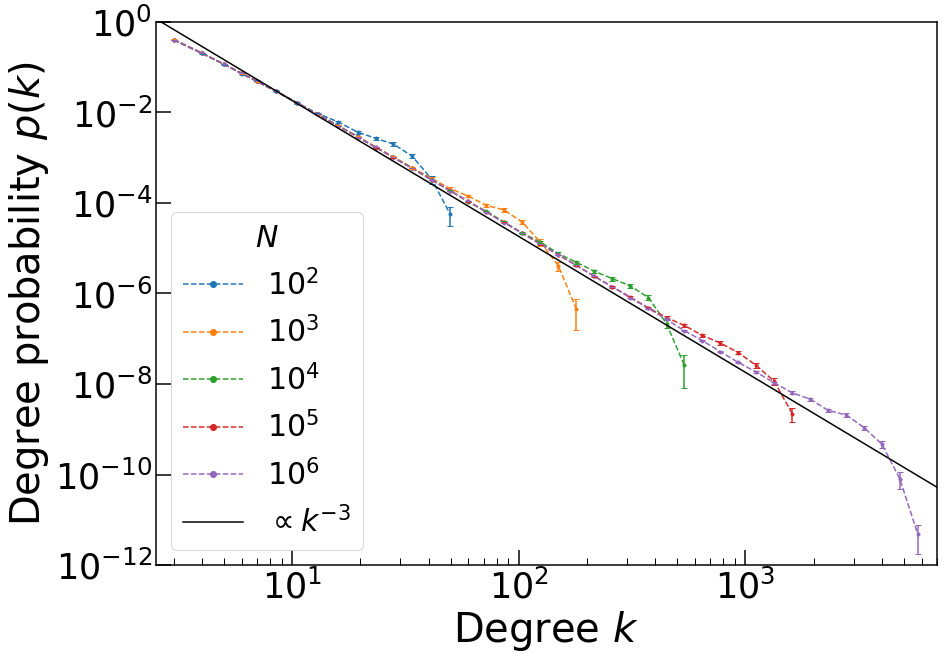

time: 5.66 s


In [578]:
degrees_Ne2 = np.load('BA_pref_Ne2_m3.npy', allow_pickle=True)
degrees_Ne3 = np.load('BA_pref_Ne3_m3.npy', allow_pickle=True)
degrees_Ne4 = np.load('BA_pref_Ne4_m3.npy', allow_pickle=True)
degrees_Ne5 = np.load('BA_pref_Ne5_m3.npy', allow_pickle=True)
degrees_Ne6 = np.load('BA_pref_Ne6_m3.npy', allow_pickle=True)

std_degree_Ne2 = np.load('BA_pref_Ne2_m3_std.npy', allow_pickle=True)
std_degree_Ne3 = np.load('BA_pref_Ne3_m3_std.npy', allow_pickle=True)
std_degree_Ne4 = np.load('BA_pref_Ne4_m3_std.npy', allow_pickle=True)
std_degree_Ne5 = np.load('BA_pref_Ne5_m3_std.npy', allow_pickle=True)
std_degree_Ne6 = np.load('BA_pref_Ne6_m3_std.npy', allow_pickle=True)

std_degree_Ne6[42] = 3e-11

bin_centres2, bin_probs2 = logbin(degrees_Ne2, scale=1.2, zeros=False)
bin_centres3, bin_probs3 = logbin(degrees_Ne3, scale=1.2, zeros=False)
bin_centres4, bin_probs4 = logbin(degrees_Ne4, scale=1.2, zeros=False)
bin_centres5, bin_probs5 = logbin(degrees_Ne5, scale=1.2, zeros=False)
bin_centres6, bin_probs6 = logbin(degrees_Ne6, scale=1.2, zeros=False)

plt.loglog(bin_centres2, bin_probs2, '.--', label="$10^{2}$")
plt.loglog(bin_centres3, bin_probs3, '.--', label="$10^{3}$")
plt.loglog(bin_centres4, bin_probs4, '.--', label="$10^{4}$")
plt.loglog(bin_centres5, bin_probs5, '.--', label="$10^{5}$")
plt.loglog(bin_centres6, bin_probs6, '.--', label="$10^{6}$")

plt.errorbar(bin_centres2, bin_probs2, fmt="none", yerr=std_degree_Ne2[2:len(bin_centres2)+2]/10, capsize=3, color='tab:blue')
plt.errorbar(bin_centres3, bin_probs3, fmt="none", yerr=std_degree_Ne3[2:len(bin_centres3)+2]/10, capsize=3, color='tab:orange')
plt.errorbar(bin_centres4, bin_probs4, fmt="none", yerr=std_degree_Ne4[2:len(bin_centres4)+2]/10, capsize=3, color='tab:green')
plt.errorbar(bin_centres5, bin_probs5, fmt="none", yerr=std_degree_Ne5[2:len(bin_centres5)+2]/10, capsize=3, color='tab:red')
plt.errorbar(bin_centres6, bin_probs6, fmt="none", yerr=std_degree_Ne6[2:len(bin_centres6)+2]/10, capsize=3, color='tab:purple')

k = np.linspace(np.min(bin_centres6)-100, np.max(bin_centres6)+10000, 1000000)
p = power_func(k, 18, -3) 
plt.loglog(k, p, '-', color="black", label=r"$\propto k^{-3}$")
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xlabel("Degree $k$", fontsize=40)
plt.ylabel("Degree probability $p(k)$", fontsize=40)
plt.legend(title="$N$", title_fontsize=30, fontsize=30, markerscale=2)
plt.axis([2.5, 7000, 1e-12, 1])
plt.show()

## Largest degree

In [ ]:
Ns = [100, 1000, 10000]
m = 3
num = 10000
att = "pref"
k1s = []
k1_list = []
for N in Ns:
    print("N:", N)
    k1, k1_all = max_deg(N, m, num, att)
    k1s.append(k1)
    k1_list.append(k1_all)
               
#np.save('BA_pref_k1s.npy', k1s)
#np.save('BA_pref_k1s_all.npy', k1_list)

In [482]:
k1_list = np.load('BA_pref_k1s_all.npy', allow_pickle=True)
degree_freqs = [Counter(k1_list[i]) for i in range(len(k1_list))]
total_max_count = [sum(degree_freqs[i].values()) for i in range(len(degree_freqs))]

degree_probs = []
for L in range(len(degree_freqs)):
    degree_prob_max = []
    maxs = []
    for (degree, count) in sorted(degree_freqs[L].items()):
        degree_prob_max.append(count/total_max_count[L]) 
        maxs.append(degree)
    degree_probs.append((maxs, degree_prob_max))

time: 8.27 ms


Study of largest degree distribution for mean and errors:

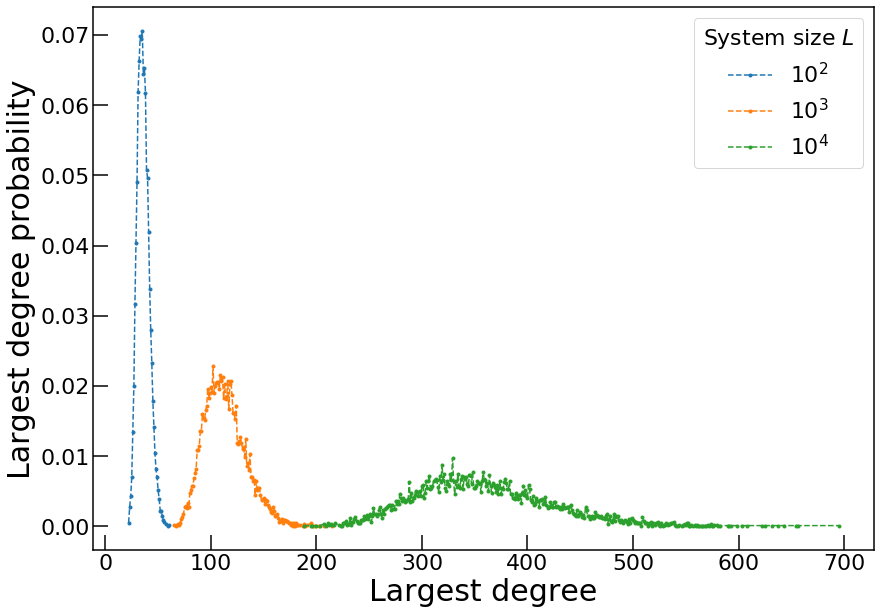

time: 856 ms


In [1030]:
N_list = ["$10^2$", "$10^3$", "$10^4$"]

for N in range(len(degree_probs)):
    plt.plot(degree_probs[N][0], degree_probs[N][1],'.--', label=N_list[N])
    
plt.xlabel("Largest degree", fontsize=30)
plt.ylabel("Largest degree probability", fontsize=30)
plt.legend(title='System size $L$')
#plt.axis((0, 500, 0, 0.5))
plt.show()

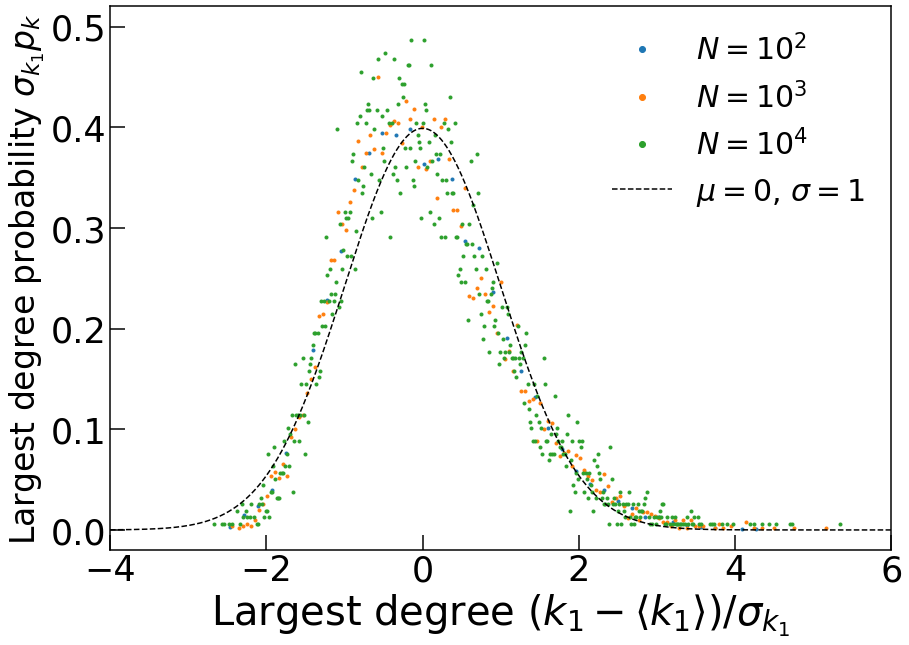

time: 886 ms


In [765]:
avg_k1 = [np.mean(k1_list[i]) for i in range(len(k1_list))]
k1_std = [np.std(k1_list[i]) for i in range(len(k1_list))]

for N in range(len(degree_probs)):
    collapsed_degree = (degree_probs[N][0] - avg_k1[N])/k1_std[N]
    collapsed_prob = np.asarray(degree_probs[N][1]) * k1_std[N]
    plt.plot(collapsed_degree, collapsed_prob,'.', label="$N=$"+N_list[N])
    
x = np.linspace(-5,6,10000)
plt.plot(x, gauss_func(x, 0, 1), '--', color='black', label='$\mu = 0$, $\sigma = 1$')

plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xlabel(r"Largest degree $(k_1 - \langle k_1 \rangle) /\sigma_{k_{1}}$", fontsize=40)
plt.ylabel("Largest degree probability $\sigma_{k_{1}}p_k$", fontsize=33)
plt.legend(fontsize = 30, markerscale=2, frameon=False)
plt.axis([-4, 6, -0.02, 0.52])
plt.show()

In [529]:
Ns = [100, 1000, 10000, 100000, 1000000]
m = 3
num = 100
att = "pref"
k1_stds = []
for N in Ns:
    print("N:", N)
    std = k1_std(N, m, num, att)
    k1_stds.append(std)

np.save('BA_pref_k1s_std.npy', k1_stds)

N: 100
N: 1000
N: 10000
N: 100000
N: 1000000
time: 56min 28s


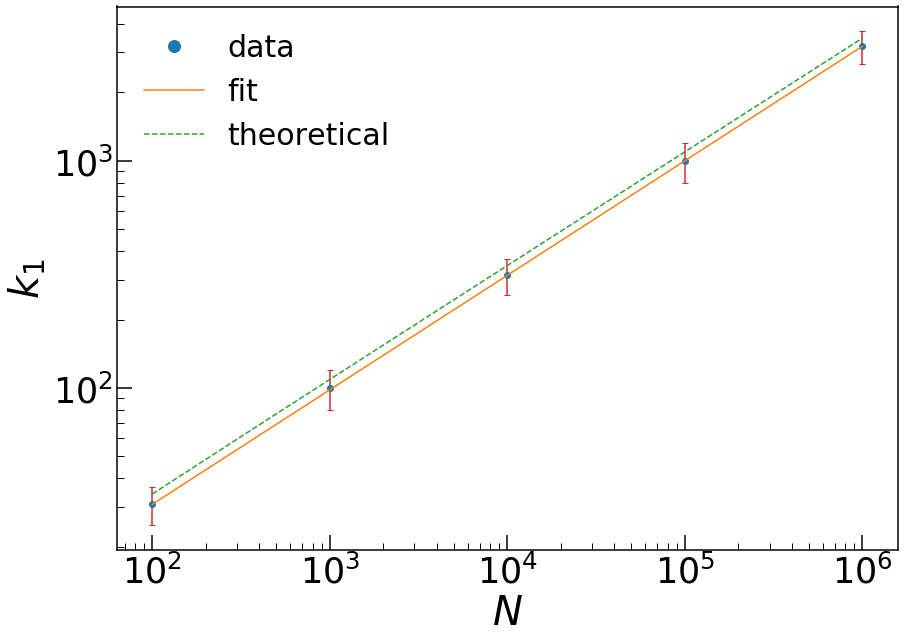

time: 586 ms


In [954]:
Ns = [100, 1000, 10000, 100000, 1000000]
k1s = np.load('BA_pref_k1s.npy', allow_pickle=True)
k1_stds = np.load('Ba_pref_k1s_std.npy', allow_pickle=True)
Nss = np.linspace(Ns[0], Ns[-1], 10000)
plt.loglog(Ns, k1s, 'o', label="data")
(a, b), cov = curve_fit(power_func, Ns, k1s)
plt.loglog(Nss, power_func(Nss, a, b), label="fit")
plt.loglog(Nss, k1_pref(Nss, 3),'--', label="theoretical")
plt.errorbar(Ns, k1s, fmt='none', yerr=k1_stds, capsize=3)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xlabel("$N$", fontsize=40)
plt.ylabel("$k_1$", fontsize=40)
plt.legend(frameon=False, fontsize=30, markerscale=2)
plt.show()

In [956]:
print("gradient:", b)
print("error on gradient:", np.sqrt(cov[0,0]))

gradient: 0.5039986203877606
error on gradient: 0.016945977269074777
time: 1.35 ms


## Data collapse for degree distribution (fixed m, vary N):

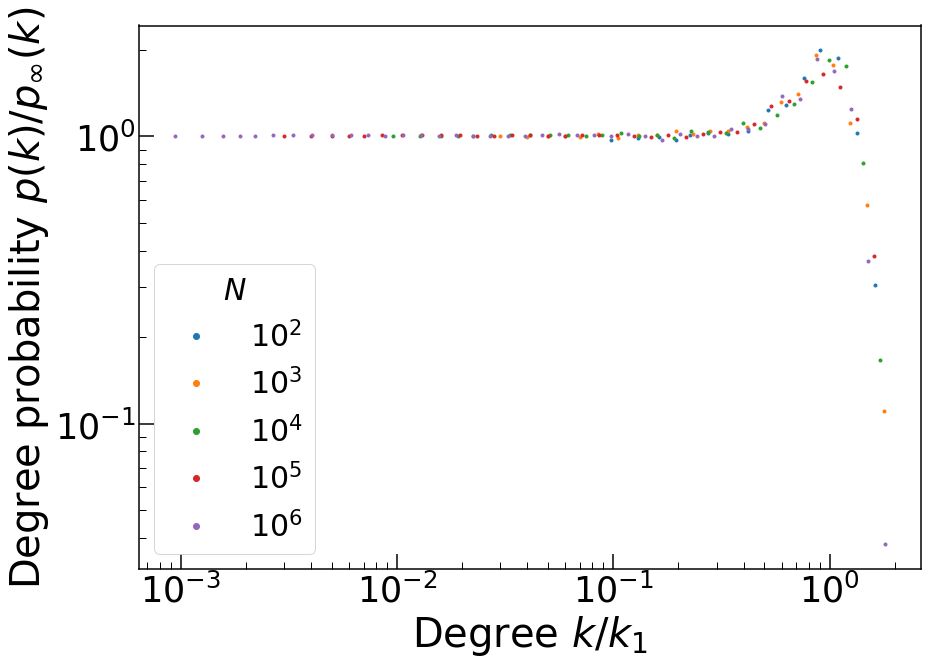

time: 3.13 s


In [579]:
degrees_Ne2 = np.load('BA_pref_Ne2_m3.npy', allow_pickle=True)
degrees_Ne3 = np.load('BA_pref_Ne3_m3.npy', allow_pickle=True)
degrees_Ne4 = np.load('BA_pref_Ne4_m3.npy', allow_pickle=True)
degrees_Ne5 = np.load('BA_pref_Ne5_m3.npy', allow_pickle=True)
degrees_Ne6 = np.load('BA_pref_Ne6_m3.npy', allow_pickle=True)

bin_centres2, bin_probs2 = logbin(degrees_Ne2, scale=1.2, zeros=False)
bin_centres3, bin_probs3 = logbin(degrees_Ne3, scale=1.2, zeros=False)
bin_centres4, bin_probs4 = logbin(degrees_Ne4, scale=1.2, zeros=False)
bin_centres5, bin_probs5 = logbin(degrees_Ne5, scale=1.2, zeros=False)
bin_centres6, bin_probs6 = logbin(degrees_Ne6, scale=1.2, zeros=False)

k = np.linspace(0.01, 10, 1000000)
plt.loglog(bin_centres2/k1s[0], bin_probs2/p_pref(3, bin_centres2), '.', label="$10^{2}$")
plt.loglog(bin_centres3/k1s[1], bin_probs3/p_pref(3, bin_centres3), '.', label="$10^{3}$")
plt.loglog(bin_centres4/k1s[2], bin_probs4/p_pref(3, bin_centres4), '.', label="$10^{4}$")
plt.loglog(bin_centres5/k1s[3], bin_probs5/p_pref(3, bin_centres5), '.', label="$10^{5}$")
plt.loglog(bin_centres6/k1s[4], bin_probs6/p_pref(3, bin_centres6), '.', label="$10^{6}$")

#plt.errorbar(bin_centres2/k1s[0], bin_probs2/p_pref(3, bin_centres2), fmt="none", yerr=std_degree_Ne2[2:len(bin_centres2)+2]/10, capsize=3, color='tab:blue')
#plt.errorbar(bin_centres3/k1s[1], bin_probs3/p_pref(3, bin_centres3), fmt="none", yerr=std_degree_Ne3[2:len(bin_centres3)+2]/10, capsize=3, color='tab:orange')
#plt.errorbar(bin_centres4/k1s[2], bin_probs4/p_pref(3, bin_centres4), fmt="none", yerr=std_degree_Ne4[2:len(bin_centres4)+2]/10, capsize=3, color='tab:green')
#plt.errorbar(bin_centres5/k1s[3], bin_probs5/p_pref(3, bin_centres5), fmt="none", yerr=std_degree_Ne5[2:len(bin_centres5)+2]/10, capsize=3, color='tab:red')
#plt.errorbar(bin_centres6/k1s[4], bin_probs6/p_pref(3, bin_centres6), fmt="none", yerr=std_degree_Ne6[2:len(bin_centres6)+2]/10, capsize=3, color='tab:purple')

p = power_func(k, 18, -3) 
#plt.loglog(k, p, '-', color="black", label=r"$\propto k^{-3}$")
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xlabel("Degree $k/k_1$", fontsize=40)
plt.ylabel("Degree probability $p(k)/p_\infty(k)$", fontsize=40)
plt.legend(title="$N$", title_fontsize=30, fontsize=30, markerscale=2)
#plt.axis([np.min(bin_centres5), np.max(bin_centres5), np.min(bin_probs5), np.max(bin_probs5)])
plt.show()

# Phase 2: Pure Random Attachment

In [11]:
N = 1000000
m = 3
num = 10
att = "rand"
degrees, size, freq, probs = deg_dist(N, m, num, att="rand")

time: 18.5 s


/Users/harvey/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in power
/Users/harvey/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


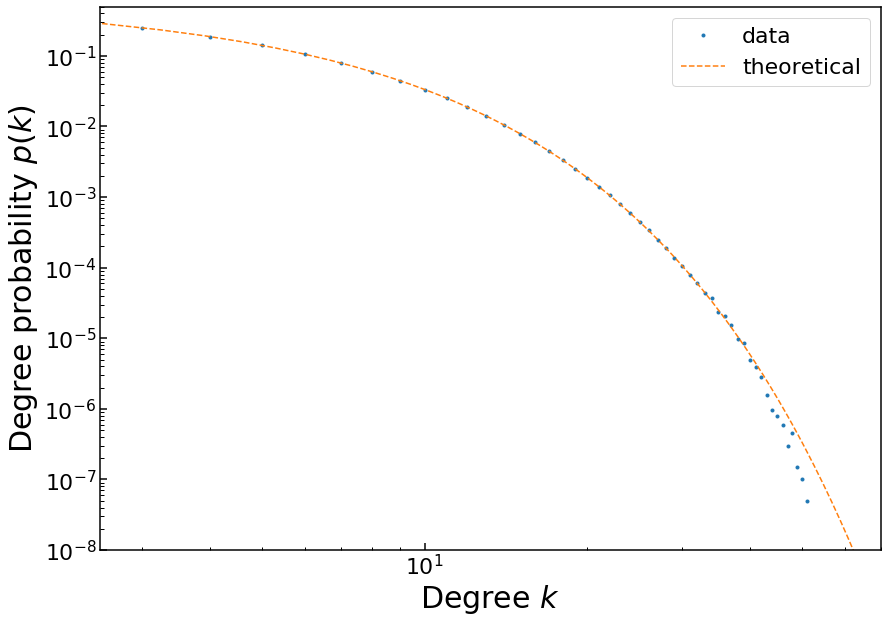

time: 927 ms


In [197]:
degrees_m3 = np.load('BA_rand_Ne5_m3.npy', allow_pickle=True)
bin_centres1, bin_probs1 = logbin(degrees_m3, scale=1.2, zeros=False)
bin_centres2, bin_probs2 = logbin(degrees_m3, scale=1., zeros=False)
ks = np.linspace(np.min(bin_centres)-100, np.max(bin_centres)+1000, 10000)
#plt.loglog(bin_centres1, bin_probs1, '--')
plt.loglog(bin_centres2, bin_probs2, '.', label="data")
plt.loglog(ks, p_rand(3, ks), '--', label="theoretical")
#plt.loglog(size, probs, 'x', label='data')
plt.xlabel("Degree $k$", fontsize=30)
plt.ylabel("Degree probability $p(k)$", fontsize=30)
plt.legend()
plt.axis([2.5, 70, 1e-8, 0.5])
plt.show()

## N=100,000 for varying m over 200 iterations:

In [40]:
N = 100000
num = 200
att = "rand"
degrees_m1 = deg_dist_logbin(100000, 1, num, att)
degrees_m3 = deg_dist_logbin(100000, 3, num, att)
degrees_m9 = deg_dist_logbin(100000, 9, num, att)
degrees_m27 = deg_dist_logbin(100000, 27, num, att)
degrees_m81 = deg_dist_logbin(100000, 81, num, att)
np.save('BA_rand_Ne5_m1.npy', degrees_m1)
np.save('BA_rand_Ne5_m3.npy', degrees_m3)
np.save('BA_rand_Ne5_m9.npy', degrees_m9)
np.save('BA_rand_Ne5_m27.npy', degrees_m27)
np.save('BA_rand_Ne5_m81.npy', degrees_m81)

time: 13h 38min 4s


In [376]:
std_degree_m1 = std_func(100000, 1, 1000, att="rand")
np.save('BA_rand_Ne5_m1_std.npy', std_degree_m1)
std_degree_m3 = std_func(100000, 3, 100, att="rand")
np.save('BA_rand_Ne5_m3_std.npy', std_degree_m3)
std_degree_m9 = std_func(100000, 9, 100, att="rand")
np.save('BA_rand_Ne5_m9_std.npy', std_degree_m9)
std_degree_m27 = std_func(100000, 27, 10, att="rand")
np.save('BA_rand_Ne5_m27_std.npy', std_degree_m27)
std_degree_m81 = std_func(100000, 81, 10, att="rand")
np.save('BA_rand_Ne5_m81_std.npy', std_degree_m81)

time: 11min 48s


In [355]:
def std_func(N, m, num, att="pref", q=0, scale=1.):
#    k1 = max_deg(N, m, num, att)
    total_degrees = []
    std_list = []
    for i in range(num):
        padding = [0 for i in range(10000000)]
        nodes, edges = ba_model(N, m, att, q=q)
        attachment = list(np.ravel(edges))
        degrees = np.unique(attachment, return_counts=True)
        bin_centres, bin_probs = logbin(degrees[1], scale, zeros=False, bin_zero=True)
        for i in range(len(bin_centres)):
            padding[bin_centres[i]] = bin_probs[i]
        std_list.append(padding)
    std = np.std(std_list, axis=0)
    return std

time: 1.73 ms


In [350]:
std_degree_m1 = std_func(100000, 1, 1000, att="rand")
np.save('BA_rand_Ne5_m1_std.npy', std_degree_m1)

time: 13min 2s


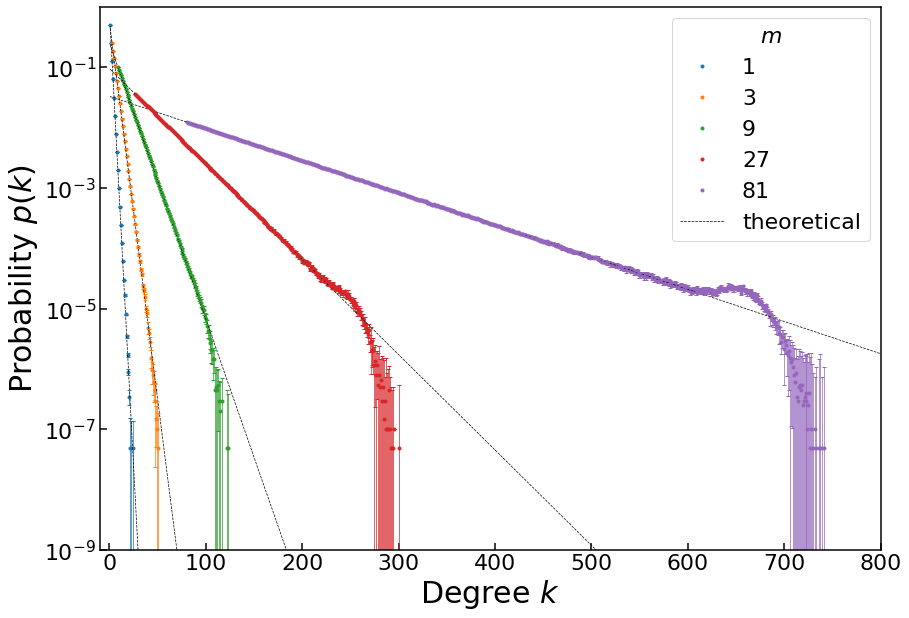

time: 1.44 s


In [390]:
degrees_m1 = np.load('BA_rand_Ne5_m1.npy', allow_pickle=True)
degrees_m3 = np.load('BA_rand_Ne5_m3.npy', allow_pickle=True)
degrees_m9 = np.load('BA_rand_Ne5_m9.npy', allow_pickle=True)
degrees_m27 = np.load('BA_rand_Ne5_m27.npy', allow_pickle=True)
degrees_m81 = np.load('BA_rand_Ne5_m81.npy', allow_pickle=True)

std_degree_m1 = np.load('BA_rand_Ne5_m1_std.npy', allow_pickle=True)
std_degree_m3 = np.load('BA_rand_Ne5_m3_std.npy', allow_pickle=True)
std_degree_m9 = np.load('BA_rand_Ne5_m9_std.npy', allow_pickle=True)
std_degree_m27 = np.load('BA_rand_Ne5_m27_std.npy', allow_pickle=True)
std_degree_m81 = np.load('BA_rand_Ne5_m81_std.npy', allow_pickle=True)

bin_centres1, bin_probs1 = logbin(degrees_m1, scale=1., zeros=False)
bin_centres3, bin_probs3 = logbin(degrees_m3, scale=1., zeros=False)
bin_centres9, bin_probs9 = logbin(degrees_m9, scale=1., zeros=False)
bin_centres27, bin_probs27 = logbin(degrees_m27, scale=1., zeros=False)
bin_centres81, bin_probs81 = logbin(degrees_m81, scale=1., zeros=False)

plt.semilogy(bin_centres1, bin_probs1, '.', label="1")
plt.semilogy(bin_centres3, bin_probs3, '.', label="3")
plt.semilogy(bin_centres9, bin_probs9, '.', label="9")
plt.semilogy(bin_centres27, bin_probs27, '.', label="27")
plt.semilogy(bin_centres81, bin_probs81, '.', label="81")

ks = np.linspace(1, 1000, 1000)
plt.semilogy(ks, p_rand(1, ks), '--', color="black",label="theoretical", linewidth=0.7)
plt.semilogy(ks, p_rand(3, ks), '--', color="black", linewidth=0.7)
plt.semilogy(ks, p_rand(9, ks), '--', color="black", linewidth=0.7)
plt.semilogy(ks, p_rand(27, ks), '--', color="black", linewidth=0.7)
plt.semilogy(ks, p_rand(81, ks), '--', color="black", linewidth=0.7)

plt.errorbar(bin_centres1, bin_probs1, fmt="none", yerr=std_degree_m1[1:len(bin_centres1)+1]/np.sqrt(1000), capsize=2, elinewidth=0.7, color='tab:blue')
plt.errorbar(bin_centres3, bin_probs3, fmt="none", yerr=std_degree_m3[1:len(bin_centres3)+1]/10, capsize=2, elinewidth=0.7, color='tab:orange')
plt.errorbar(bin_centres9, bin_probs9, fmt="none", yerr=std_degree_m9[1:len(bin_centres9)+1]/10, capsize=2, elinewidth=0.7, color='tab:green')
plt.errorbar(bin_centres27, bin_probs27, fmt="none", yerr=std_degree_m27[1:len(bin_centres27)+1]/10, capsize=2, elinewidth=0.7, color='tab:red')
plt.errorbar(bin_centres81, bin_probs81, fmt="none", yerr=std_degree_m81[1:len(bin_centres81)+1]/10, capsize=2, elinewidth=0.7, color='tab:purple')

k = np.linspace(np.min(bin_centres1)-0.15, np.max(bin_centres9)+400, 1000000)
p = power_func(k, 1, -3) 
#plt.loglog(k, p, '-', color="black", label=r"$\propto k^{-3}$")

plt.xlabel("Degree $k$", fontsize=30)
plt.ylabel("Probability $p(k)$", fontsize=30)
plt.axis([-10, 800, 1e-9, 1])
plt.legend(title="$m$")
plt.show()

/Users/harvey/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


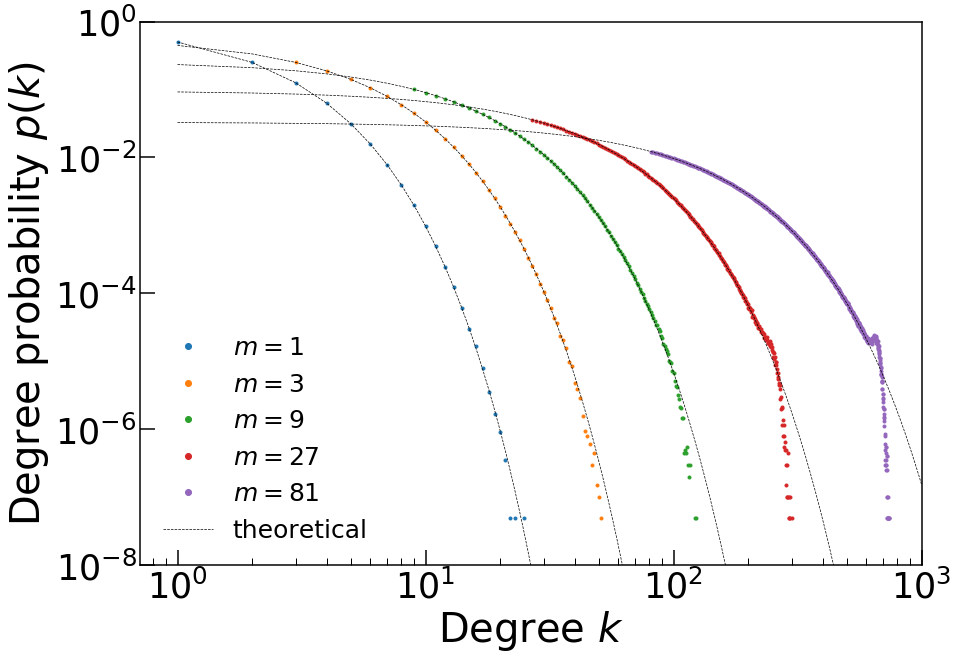

time: 2.43 s


In [944]:
degrees_m1 = np.load('BA_rand_Ne5_m1.npy', allow_pickle=True)
degrees_m3 = np.load('BA_rand_Ne5_m3.npy', allow_pickle=True)
degrees_m9 = np.load('BA_rand_Ne5_m9.npy', allow_pickle=True)
degrees_m27 = np.load('BA_rand_Ne5_m27.npy', allow_pickle=True)
degrees_m81 = np.load('BA_rand_Ne5_m81.npy', allow_pickle=True)

bin_centres1, bin_probs1 = logbin(degrees_m1, scale=1., zeros=False)
bin_centres3, bin_probs3 = logbin(degrees_m3, scale=1., zeros=False)
bin_centres9, bin_probs9 = logbin(degrees_m9, scale=1., zeros=False)
bin_centres27, bin_probs27 = logbin(degrees_m27, scale=1., zeros=False)
bin_centres81, bin_probs81 = logbin(degrees_m81, scale=1., zeros=False)

plt.loglog(bin_centres1, bin_probs1, '.', label="$m=1$")
plt.loglog(bin_centres3, bin_probs3, '.', label="$m=3$")
plt.loglog(bin_centres9, bin_probs9, '.', label="$m=9$")
plt.loglog(bin_centres27, bin_probs27, '.', label="$m=27$")
plt.loglog(bin_centres81, bin_probs81, '.', label="$m=81$")

ks = np.linspace(1, 1000, 1000)

plt.loglog(ks, p_rand(1, ks), '--', color="black",label="theoretical", linewidth=0.7)
plt.loglog(ks, p_rand(3, ks), '--', color="black", linewidth=0.7)
plt.loglog(ks, p_rand(9, ks), '--', color="black", linewidth=0.7)
plt.loglog(ks, p_rand(27, ks), '--', color="black", linewidth=0.7)
plt.loglog(ks, p_rand(81, ks), '--', color="black", linewidth=0.7)

p = power_func(k, 1, -3) 
#plt.loglog(k, p, '-', color="black", label=r"$\propto k^{-3}$")

plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xlabel("Degree $k$", fontsize=40)
plt.ylabel("Degree probability $p(k)$", fontsize=40)
plt.axis([0, 1000, 1e-8, 1])
plt.legend(fontsize=25, frameon=False, markerscale=2)
plt.show()

## Cumulative distribution plot for KS:

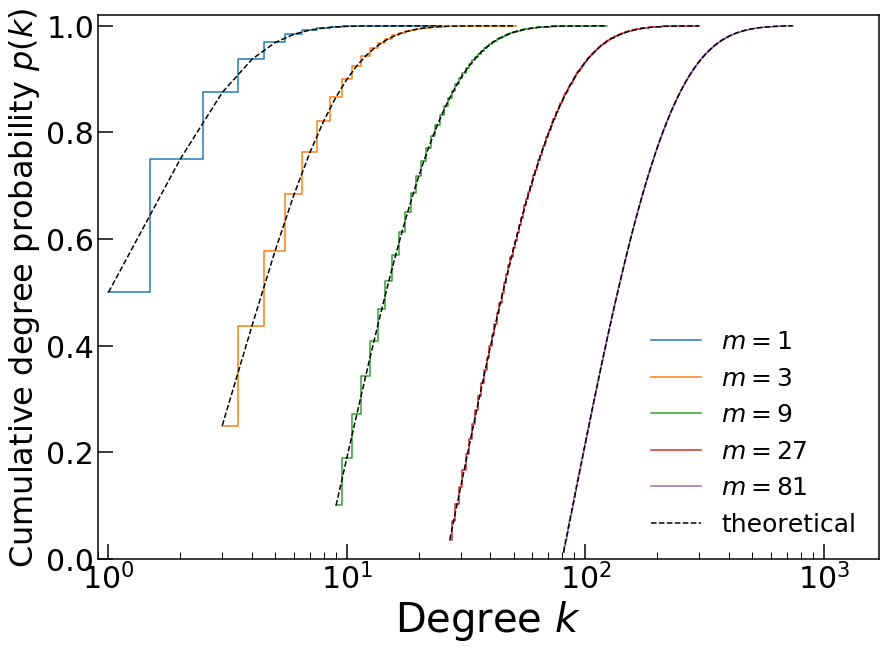

3.7966180960746776e-05
0.00010468877402802779
2.300285126027868e-05
8.913119212772269e-05
2.559203471701188e-05
time: 1.75 s


In [1032]:
ks1 = np.linspace(np.min(bin_centres1), np.max(bin_centres1), 10000)
cum_data1 = np.cumsum(bin_probs1)/np.sum(bin_probs1)
cum_theory1 = np.cumsum(p_rand(1, bin_centres1))/np.sum(p_rand(1, bin_centres1))
plt.step(bin_centres1, cum_data1, label='$m=1$', color='tab:blue', where='mid')
plt.semilogx(bin_centres1, cum_theory1,'--', color="black")

ks3 = np.linspace(np.min(bin_centres3), np.max(bin_centres3), 10000)
cum_data3 = np.cumsum(bin_probs3)/np.sum(bin_probs3)
cum_theory3 = np.cumsum(p_rand(3, bin_centres3))/np.sum(p_rand(3, bin_centres3))
plt.step(bin_centres3, cum_data3, label = "$m=3$", color='tab:orange', where='mid')
plt.semilogx(bin_centres3, cum_theory3,'--', color="black")

ks9 = np.linspace(np.min(bin_centres9), np.max(bin_centres9), 10000)
cum_data9 = np.cumsum(bin_probs9)/np.sum(bin_probs9)
cum_theory9 = np.cumsum(p_rand(9, bin_centres9))/np.sum(p_rand(9, bin_centres9))
plt.step(bin_centres9, cum_data9, label = "$m=9$", color='tab:green', where='mid')
plt.semilogx(bin_centres9, cum_theory9,'--', color="black")

ks27 = np.linspace(np.min(bin_centres27), np.max(bin_centres27), 10000)
cum_data27 = np.cumsum(bin_probs27)/np.sum(bin_probs27)
cum_theory27 = np.cumsum(p_rand(27, bin_centres27))/np.sum(p_rand(27, bin_centres27))
plt.step(bin_centres27, cum_data27, label = "$m=27$", color='tab:red', where='mid')
plt.semilogx(bin_centres27, cum_theory27,'--', color="black")

ks81 = np.linspace(np.min(bin_centres81), np.max(bin_centres81), 10000)
cum_data81 = np.cumsum(bin_probs81)/np.sum(bin_probs81)
cum_theory81 = np.cumsum(p_rand(81, bin_centres81))/np.sum(p_rand(81, bin_centres81))
plt.step(bin_centres81, cum_data81, label = "$m=81$", color='tab:purple', where='mid')
plt.semilogx(bin_centres81, cum_theory81,'--', color="black", label='theoretical')

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel("Degree $k$", fontsize=40)
plt.ylabel("Cumulative degree probability $p(k)$", fontsize=32)
plt.legend(fontsize=25, markerscale=2, frameon=False)
plt.axis([0.9, 1700, 0, 1.02])
plt.show()

m_list = [bin_centres1, bin_centres3, bin_centres9, bin_centres27, bin_centres81]
cum_theory_list = [cum_theory1, cum_theory3, cum_theory9, cum_theory27, cum_theory81]
cum_data_list = [cum_data1, cum_data3, cum_data9, cum_data27, cum_data81]

max_diff_list = []
for m in range(len(m_list)):
    max_diff = 0
    for i in range(len(m_list)):
        diff = np.linalg.norm(cum_theory_list[m][i] - cum_data_list[m][i])
        if diff > max_diff:
            max_diff = diff
    max_diff_list.append(max_diff)

    print(max_diff)

KS statistics:

In [1033]:
n = [len(bin_centres1), len(bin_centres3), len(bin_centres9), len(bin_centres27), len(bin_centres81)]
alpha = 0.05
print(max_diff_list)
for D in range(len(max_diff_list)):
    ks_test = max_diff_list[D] - ((1/np.sqrt(n[D])) * np.sqrt(-np.log(alpha/2)))
    print("thresh:", ((1/np.sqrt(n[D])) * np.sqrt(-np.log(alpha/2))))
    print(ks_test)

[3.7966180960746776e-05, 0.00010468877402802779, 2.300285126027868e-05, 8.913119212772269e-05, 2.559203471701188e-05]
thresh: 0.0013581015157406195
-0.0013201353347798727
thresh: 0.0013581015157406195
-0.0012534127417125917
thresh: 0.0013581015157406195
-0.0013350986644803408
thresh: 0.0013581015157406195
-0.0012689703236128968
thresh: 0.0013581015157406195
-0.0013325094810236076
time: 4.79 ms


## Largest degree vs. N for varying m over 200 iterations:

In [51]:
N = 100
num = 200
att = "rand"
degrees_m1 = deg_dist_logbin(N, 1, num, att)
degrees_m3 = deg_dist_logbin(N, 3, num, att)
degrees_m9 = deg_dist_logbin(N, 9, num, att)
degrees_m27 = deg_dist_logbin(N, 27, num, att)
degrees_m81 = deg_dist_logbin(N, 81, num, att)
np.save('BA_rand_Ne2_m1.npy', degrees_m1)
np.save('BA_rand_Ne2_m3.npy', degrees_m3)
np.save('BA_rand_Ne2_m9.npy', degrees_m9)
np.save('BA_rand_Ne2_m27.npy', degrees_m27)
np.save('BA_rand_Ne2_m81.npy', degrees_m81)

time: 4.37 s


In [52]:
N = 1000
num = 200
att = "rand"
degrees_m1 = deg_dist_logbin(N, 1, num, att)
degrees_m3 = deg_dist_logbin(N, 3, num, att)
degrees_m9 = deg_dist_logbin(N, 9, num, att)
degrees_m27 = deg_dist_logbin(N, 27, num, att)
degrees_m81 = deg_dist_logbin(N, 81, num, att)
np.save('BA_rand_Ne3_m1.npy', degrees_m1)
np.save('BA_rand_Ne3_m3.npy', degrees_m3)
np.save('BA_rand_Ne3_m9.npy', degrees_m9)
np.save('BA_rand_Ne3_m27.npy', degrees_m27)
np.save('BA_rand_Ne3_m81.npy', degrees_m81)

time: 58.1 s


In [53]:
N = 10000
num = 200
att = "rand"
degrees_m1 = deg_dist_logbin(N, 1, num, att)
degrees_m3 = deg_dist_logbin(N, 3, num, att)
degrees_m9 = deg_dist_logbin(N, 9, num, att)
degrees_m27 = deg_dist_logbin(N, 27, num, att)
degrees_m81 = deg_dist_logbin(N, 81, num, att)
np.save('BA_rand_Ne4_m1.npy', degrees_m1)
np.save('BA_rand_Ne4_m3.npy', degrees_m3)
np.save('BA_rand_Ne4_m9.npy', degrees_m9)
np.save('BA_rand_Ne4_m27.npy', degrees_m27)
np.save('BA_rand_Ne4_m81.npy', degrees_m81)

time: 11min 27s


In [54]:
degrees_Ne2_m1 = np.load('BA_rand_Ne2_m1.npy', allow_pickle=True)
degrees_Ne2_m3 = np.load('BA_rand_Ne2_m3.npy', allow_pickle=True)
degrees_Ne2_m9 = np.load('BA_rand_Ne2_m9.npy', allow_pickle=True)
degrees_Ne2_m27 = np.load('BA_rand_Ne2_m27.npy', allow_pickle=True)
degrees_Ne2_m81 = np.load('BA_rand_Ne2_m81.npy', allow_pickle=True)

degrees_Ne3_m1 = np.load('BA_rand_Ne3_m1.npy', allow_pickle=True)
degrees_Ne3_m3 = np.load('BA_rand_Ne3_m3.npy', allow_pickle=True)
degrees_Ne3_m9 = np.load('BA_rand_Ne3_m9.npy', allow_pickle=True)
degrees_Ne3_m27 = np.load('BA_rand_Ne3_m27.npy', allow_pickle=True)
degrees_Ne3_m81 = np.load('BA_rand_Ne3_m81.npy', allow_pickle=True)

degrees_Ne4_m1 = np.load('BA_rand_Ne4_m1.npy', allow_pickle=True)
degrees_Ne4_m3 = np.load('BA_rand_Ne4_m3.npy', allow_pickle=True)
degrees_Ne4_m9 = np.load('BA_rand_Ne4_m9.npy', allow_pickle=True)
degrees_Ne4_m27 = np.load('BA_rand_Ne4_m27.npy', allow_pickle=True)
degrees_Ne4_m81 = np.load('BA_rand_Ne4_m81.npy', allow_pickle=True)

degrees_Ne5_m1 = np.load('BA_rand_Ne5_m1.npy', allow_pickle=True)
degrees_Ne5_m3 = np.load('BA_rand_Ne5_m3.npy', allow_pickle=True)
degrees_Ne5_m9 = np.load('BA_rand_Ne5_m9.npy', allow_pickle=True)
degrees_Ne5_m27 = np.load('BA_rand_Ne5_m27.npy', allow_pickle=True)
degrees_Ne5_m81 = np.load('BA_rand_Ne5_m81.npy', allow_pickle=True)

k1_Ne2_m1 = np.max(degrees_Ne2_m1)
k1_Ne2_m3 = np.max(degrees_Ne2_m3)
k1_Ne2_m9 = np.max(degrees_Ne2_m9)
k1_Ne2_m27 = np.max(degrees_Ne2_m27)
k1_Ne2_m81 = np.max(degrees_Ne2_m81)

k1_Ne3_m1 = np.max(degrees_Ne3_m1)
k1_Ne3_m3 = np.max(degrees_Ne3_m3)
k1_Ne3_m9 = np.max(degrees_Ne3_m9)
k1_Ne3_m27 = np.max(degrees_Ne3_m27)
k1_Ne3_m81 = np.max(degrees_Ne3_m81)

k1_Ne4_m1 = np.max(degrees_Ne4_m1)
k1_Ne4_m3 = np.max(degrees_Ne4_m3)
k1_Ne4_m9 = np.max(degrees_Ne4_m9)
k1_Ne4_m27 = np.max(degrees_Ne4_m27)
k1_Ne4_m81 = np.max(degrees_Ne4_m81)

k1_Ne5_m1 = np.max(degrees_Ne5_m1)
k1_Ne5_m3 = np.max(degrees_Ne5_m3)
k1_Ne5_m9 = np.max(degrees_Ne5_m9)
k1_Ne5_m27 = np.max(degrees_Ne5_m27)
k1_Ne5_m81 = np.max(degrees_Ne5_m81)

time: 529 ms


In [415]:
Ns = [100, 1000, 10000, 100000]
ms = [1, 3, 9, 27, 81]
num = 100
att = "rand"
k1_stds = [[] for i in range(len(ms))]
for i in range(len(ms)):
    print("m:", ms[i])
    for N in Ns:
        print("N:", N)
        std = k1_std(N, ms[i], num, att=att)
        k1_stds[i].append(std)

np.save('BA_rand_k1s_std.npy', k1_stds)

m: 1
N: 100
N: 1000
N: 10000
N: 100000
m: 3
N: 100
N: 1000
N: 10000
N: 100000
m: 9
N: 100
N: 1000
N: 10000
N: 100000
m: 27
N: 100
N: 1000
N: 10000
N: 100000
m: 81
N: 100
N: 1000
N: 10000
N: 100000
time: 12h 21min 29s


In [871]:
Ns = [100, 1000, 10000, 100000]
ms = [1, 3, 9, 27, 81]
num = 50
att = "rand"
k1s = [[] for i in range(len(ms))]
k1_lists = [[] for i in range(len(ms))]
for i in range(len(ms)):
    print("m:", ms[i])
    for N in Ns:
        print("N:", N)
        k1, k1_list = max_deg(N, ms[i], num, att=att)
        #k1s[i].append(k1)
        k1_lists[i].append(k1_list)
               
#np.save('BA_rand_k1s.npy', k1s)
np.save('BA_rand_k1s_all.npy', k1_lists)

m: 1
N: 100
N: 1000
N: 10000
N: 100000
m: 3
N: 100
N: 1000
N: 10000
N: 100000
m: 9
N: 100
N: 1000
N: 10000
N: 100000
m: 27
N: 100
N: 1000
N: 10000
N: 100000
m: 81
N: 100
N: 1000
N: 10000
N: 100000
time: 9h 27min 47s


/Users/harvey/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


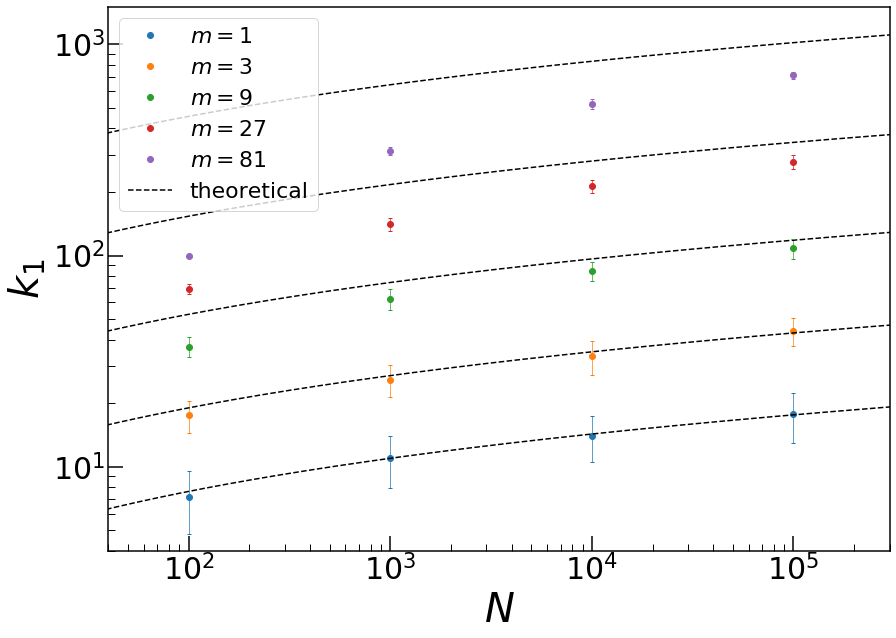

time: 17.5 s


In [835]:
Ns = [1e2, 1e3, 1e4, 1e5]
Nss = np.linspace(Ns[0]-100, Ns[-1]+1000000, 1000000)
k1s = np.load('BA_rand_k1s.npy', allow_pickle=True)
k1_stds = np.load('BA_rand_k1s_std.npy', allow_pickle=True)

k1_m1 = k1s[0]
k1_m3 = k1s[1]
k1_m9 = k1s[2]
k1_m27 = k1s[3]
k1_m81 = k1s[4]

k1_m1_std = k1_stds[0]
k1_m3_std = k1_stds[1]
k1_m9_std = k1_stds[2]
k1_m27_std = k1_stds[3]
k1_m81_std = k1_stds[4]

k1_m1_theory = k1_rand(Nss, 1)
k1_m3_theory = k1_rand(Nss, 3)
k1_m9_theory = k1_rand(Nss, 9)
k1_m27_theory = k1_rand(Nss, 27)
k1_m81_theory = k1_rand(Nss, 81)

plt.loglog(Ns, k1_m1, 'o', label="$m=1$")
plt.loglog(Ns, k1_m3, 'o', label="$m=3$")
plt.loglog(Ns, k1_m9, 'o', label="$m=9$")
plt.loglog(Ns, k1_m27, 'o', label="$m=27$")
plt.loglog(Ns, k1_m81, 'o', label="$m=81$")

plt.loglog(Nss, k1_m1_theory, '--', color="black")
plt.loglog(Nss, k1_m3_theory, '--', color="black")
plt.loglog(Nss, k1_m9_theory, '--', color="black")
plt.loglog(Nss, k1_m27_theory, '--', color="black")
plt.loglog(Nss, k1_m81_theory, '--', color="black", label="theoretical")

plt.errorbar(Ns, k1_m1, fmt="none", yerr=k1_m1_std, capsize=2, elinewidth=0.7, color='tab:blue')
plt.errorbar(Ns, k1_m3, fmt="none", yerr=k1_m3_std, capsize=2, elinewidth=0.7, color='tab:orange')
plt.errorbar(Ns, k1_m9, fmt="none", yerr=k1_m9_std, capsize=2, elinewidth=0.7, color='tab:green')
plt.errorbar(Ns, k1_m27, fmt="none", yerr=k1_m27_std, capsize=2, elinewidth=0.7, color='tab:red')
plt.errorbar(Ns, k1_m81, fmt="none", yerr=k1_m81_std, capsize=2, elinewidth=0.7, color='tab:purple')

#(a, b), cov = curve_fit(power_func, Ns, k1s)
#plt.loglog(Nss, power_func(Nss, a, b), label="fit")

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel("$N$", fontsize=40)
plt.ylabel("$k_1$", fontsize=40)
plt.legend()
plt.axis([40, 300000, 4, 1500])
plt.show()

/Users/harvey/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


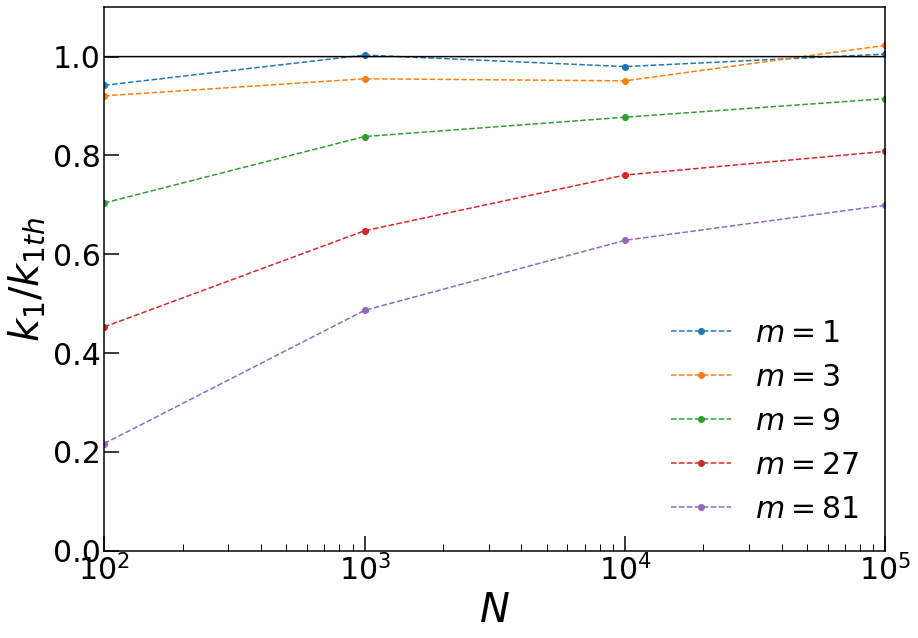

time: 3.7 s


In [973]:
Ns = [1e2, 1e3, 1e4, 1e5]
Nss = np.linspace(Ns[0]-100, Ns[-1]+1000000, 1000000)
k1s = np.load('BA_rand_k1s.npy', allow_pickle=True)
k1_stds = np.load('BA_rand_k1s_std.npy', allow_pickle=True)

k1_m1 = k1s[0]
k1_m3 = k1s[1]
k1_m9 = k1s[2]
k1_m27 = k1s[3]
k1_m81 = k1s[4]

k1_m1_std = k1_stds[0]
k1_m3_std = k1_stds[1]
k1_m9_std = k1_stds[2]
k1_m27_std = k1_stds[3]
k1_m81_std = k1_stds[4]

k1_m1_theory = k1_rand(Nss, 1)
k1_m3_theory = k1_rand(Nss, 3)
k1_m9_theory = k1_rand(Nss, 9)
k1_m27_theory = k1_rand(Nss, 27)
k1_m81_theory = k1_rand(Nss, 81)

plt.semilogx(Ns, k1_m1/k1_rand(Ns, 1), 'o--', label="$m=1$")
plt.semilogx(Ns, k1_m3/k1_rand(Ns, 3), 'o--', label="$m=3$")
plt.semilogx(Ns, k1_m9/k1_rand(Ns, 9), 'o--', label="$m=9$")
plt.semilogx(Ns, k1_m27/k1_rand(Ns, 27), 'o--', label="$m=27$")
plt.semilogx(Ns, k1_m81/k1_rand(Ns, 81), 'o--', label="$m=81$")
plt.semilogx(Nss, [1 for i in range(len(Nss))], '-', color="black")

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel("$N$", fontsize=40)
plt.ylabel("$k_1/k_{1th}$", fontsize=40)
plt.legend(frameon=False, fontsize=30)
plt.axis([100, 100000, 0, 1.1])
plt.show()

# Phase 3: Random Walk

In [425]:
N = 100000
m = 3
att = "walk"
num = 200

degrees_pref = deg_dist_logbin(N, m, num, att, q=0.99)
np.save('BA_walk_Ne5_m3_q1.npy', degrees_pref)

degrees_walk = deg_dist_logbin(N, m, num, att, q=0.5)
np.save('BA_walk_Ne5_m3_q5e-1.npy', degrees_walk)

degrees_rand = deg_dist_logbin(N, m, num, att, q=0)
np.save('BA_walk_Ne5_m3_q0.npy', degrees_rand)

time: 5h 40min 2s


In [1006]:
N = 100000
m = 3
att = "walk"
num = 300

degrees_walk = deg_dist_logbin(N, m, num, att, q=0.5)
degrees_rand = deg_dist_logbin(N, m, num, att, q=0)

bin_centres_rand, bin_probs_rand = logbin(degrees_rand, scale=1.2, zeros=False)
bin_centres_walk, bin_probs_walk = logbin(degrees_walk, scale=1.2, zeros=False)

bin_centres_rand1, bin_probs_rand1 = logbin(degrees_rand, scale=1., zeros=False)
bin_centres_walk1, bin_probs_walk1 = logbin(degrees_walk, scale=1., zeros=False)

time: 13h 16min 22s


/Users/harvey/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


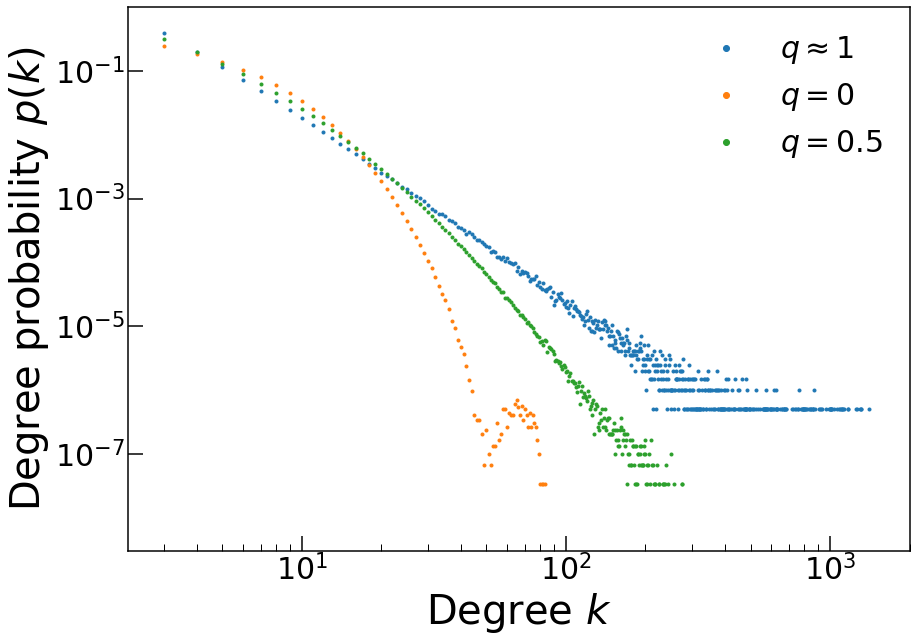

time: 1.38 s


In [1021]:
degrees_pref = np.load('BA_walk_Ne5_m3_q1.npy', allow_pickle=True)
degrees_walk = np.load('BA_walk_Ne5_m3_q5e-1.npy', allow_pickle=True)
degrees_rand = np.load('BA_walk_Ne5_m3_q0.npy', allow_pickle=True)

pref_std = np.load('BA_walk_Ne5_m3_q1_std.npy', allow_pickle=True)
rand_std = np.load('BA_walk_Ne5_m3_q5e-1_std.npy', allow_pickle=True)
walk_std = np.load('BA_walk_Ne5_m3_q0_std.npy', allow_pickle=True)

bin_centres_pref1, bin_probs_pref1 = logbin(degrees_pref, scale=1., zeros=False)
bin_centres_rand1, bin_probs_rand1 = logbin(degrees_rand, scale=1., zeros=False)
bin_centres_walk1, bin_probs_walk1 = logbin(degrees_walk, scale=1., zeros=False)

bin_centres_pref, bin_probs_pref = logbin(degrees_pref, scale=1.2, zeros=False)
bin_centres_rand, bin_probs_rand = logbin(degrees_rand, scale=1.2, zeros=False)
bin_centres_walk, bin_probs_walk = logbin(degrees_walk, scale=1.2, zeros=False)

plt.loglog(bin_centres_pref1, bin_probs_pref1, '.', label=r"$q\approx 1$")
plt.loglog(bin_centres_rand1, bin_probs_rand1, '.', label="$q=0$")
plt.loglog(bin_centres_walk1, bin_probs_walk1, '.', label="$q=0.5$")

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel("Degree $k$", fontsize=40)
plt.ylabel("Degree probability $p(k)$", fontsize=40)
plt.legend(fontsize=30, frameon=False, markerscale=2)
plt.axis([0, 2000, 3e-9, 1])
plt.show()

/Users/harvey/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


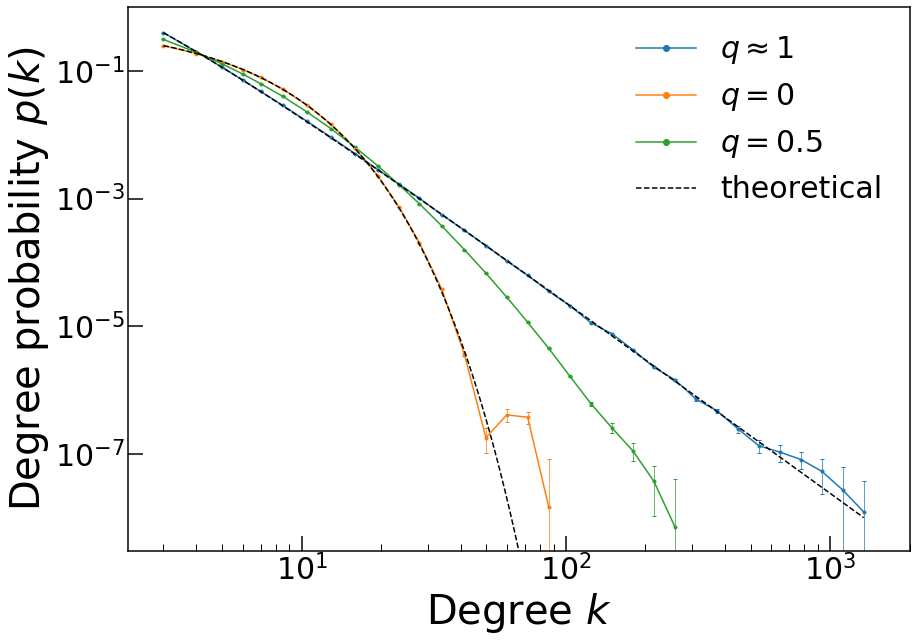

time: 1.48 s


In [1022]:
degrees_pref = np.load('BA_walk_Ne5_m3_q1.npy', allow_pickle=True)
degrees_walk = np.load('BA_walk_Ne5_m3_q5e-1.npy', allow_pickle=True)
degrees_rand = np.load('BA_walk_Ne5_m3_q0.npy', allow_pickle=True)

pref_std = np.load('BA_walk_Ne5_m3_q1_std.npy', allow_pickle=True)
rand_std = np.load('BA_walk_Ne5_m3_q5e-1_std.npy', allow_pickle=True)
walk_std = np.load('BA_walk_Ne5_m3_q0_std.npy', allow_pickle=True)

bin_centres_pref1, bin_probs_pref1 = logbin(degrees_pref, scale=1., zeros=False)
bin_centres_rand1, bin_probs_rand1 = logbin(degrees_rand, scale=1., zeros=False)
bin_centres_walk1, bin_probs_walk1 = logbin(degrees_walk, scale=1., zeros=False)

bin_centres_pref, bin_probs_pref = logbin(degrees_pref, scale=1.2, zeros=False)
bin_centres_rand, bin_probs_rand = logbin(degrees_rand, scale=1.2, zeros=False)
bin_centres_walk, bin_probs_walk = logbin(degrees_walk, scale=1.2, zeros=False)

#plt.loglog(bin_centres_pref1, bin_probs_pref1, '.')
#plt.loglog(bin_centres_rand1, bin_probs_rand1, '.')
#plt.loglog(bin_centres_walk1, bin_probs_walk1, '.')

plt.loglog(bin_centres_pref, bin_probs_pref, '.-', label=r"$q\approx 1$", color='tab:blue')
plt.loglog(bin_centres_rand, bin_probs_rand, '.-', label="$q=0$", color='tab:orange')
plt.loglog(bin_centres_walk, bin_probs_walk, '.-',label="$q=0.5$", color='tab:green')

plt.errorbar(bin_centres_pref, bin_probs_pref, fmt="none", yerr=pref_std[0:len(bin_centres_pref)]/3000, capsize=2, elinewidth=0.7, color='tab:blue')
plt.errorbar(bin_centres_rand, bin_probs_rand, fmt="none", yerr=rand_std[0:len(bin_centres_rand)]/3000, capsize=2, elinewidth=0.7, color='tab:orange')
plt.errorbar(bin_centres_walk, bin_probs_walk, fmt="none", yerr=walk_std[0:len(bin_centres_walk)]/3000, capsize=2, elinewidth=0.7, color='tab:green')

k = np.linspace(np.min(bin_centres_pref), np.max(bin_centres_pref), 100000)
plt.loglog(k, p_pref(3, k), '--', c='black', label='theoretical')
plt.loglog(k, p_rand(3, k), '--', c='black')

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel("Degree $k$", fontsize=40)
plt.ylabel("Degree probability $p(k)$", fontsize=40)
plt.legend(fontsize=30, frameon=False, markerscale=2)
plt.axis([0, 2000, 3e-9, 1])
plt.show()

## Cumulative distribution for q=0 and q=1, for KS:

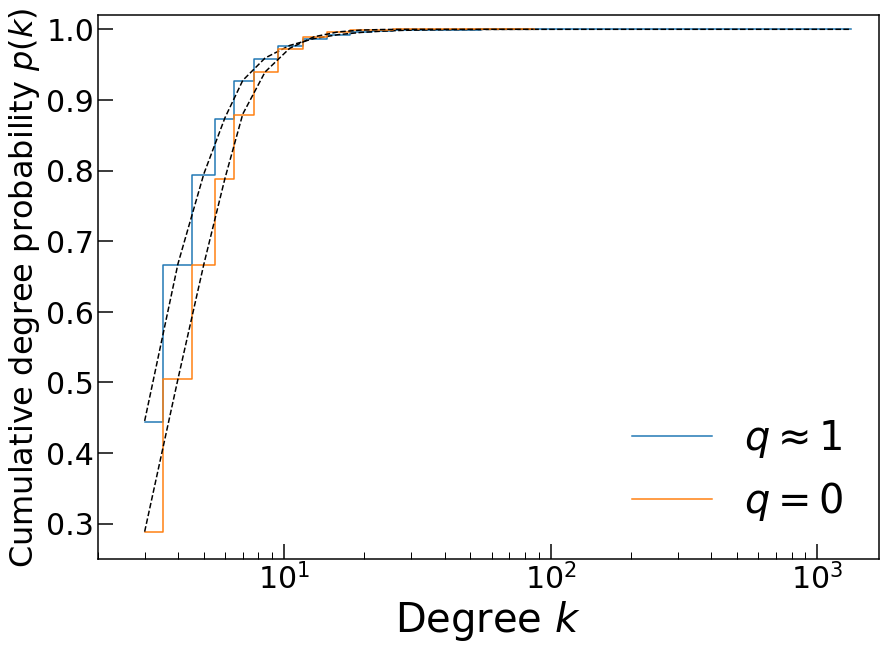

0.002023417643675973
0.0005922965292788351
time: 376 ms


In [1023]:
ks_pref = np.linspace(np.min(bin_centres_pref), np.max(bin_centres_pref), 10000)
cum_data_pref = np.cumsum(bin_probs_pref)/np.sum(bin_probs_pref)
cum_theory_pref = np.cumsum(p_pref(3, bin_centres_pref))/np.sum(p_pref(3, bin_centres_pref))
plt.step(bin_centres_pref, cum_data_pref, label=r'$q\approx 1$', color='tab:blue', where='mid')
plt.semilogx(bin_centres_pref, cum_theory_pref,'--', color="black")

ks_rand = np.linspace(np.min(bin_centres_rand), np.max(bin_centres_rand), 10000)
cum_data_rand = np.cumsum(bin_probs_rand)/np.sum(bin_probs_rand)
cum_theory_rand = np.cumsum(p_rand(3, bin_centres_rand))/np.sum(p_rand(3, bin_centres_rand))
plt.step(bin_centres_rand, cum_data_rand, label = "$q=0$", color='tab:orange', where='mid')
plt.semilogx(bin_centres_rand, cum_theory_rand,'--', color="black")

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel("Degree $k$", fontsize=40)
plt.ylabel("Cumulative degree probability $p(k)$", fontsize=32)
plt.legend(fontsize=40, markerscale=2, frameon=False, loc='lower right')
plt.axis([2, 1700, 0.25, 1.02])
plt.show()

m_list = [bin_centres_pref, bin_centres_rand]
cum_theory_list = [cum_theory_pref, cum_theory_rand]
cum_data_list = [cum_data_pref, cum_data_rand]

max_diff_list = []
for m in range(len(m_list)):
    max_diff = 0
    for i in range(len(m_list)):
        diff = np.linalg.norm(cum_theory_list[m][i] - cum_data_list[m][i])
        if diff > max_diff:
            max_diff = diff
    max_diff_list.append(max_diff)

    print(max_diff)

KS statistics:

In [1025]:
n = [len(bin_centres_pref1), len(bin_centres_rand1)]
n = [200000, 200000]
print(n)
alpha = 0.05
print(max_diff_list)
for D in range(len(max_diff_list)):
    ks_test = max_diff_list[D] - ((1/np.sqrt(n[D])) * np.sqrt(-np.log(alpha/2)))
    print("thresh:", ((1/np.sqrt(n[D])) * np.sqrt(-np.log(alpha/2))))
    print(ks_test)

[200000, 200000]
[0.002023417643675973, 0.0005922965292788351]
thresh: 0.004294694083467376
-0.002271276439791403
thresh: 0.004294694083467376
-0.003702397554188541
time: 2.23 ms
